## 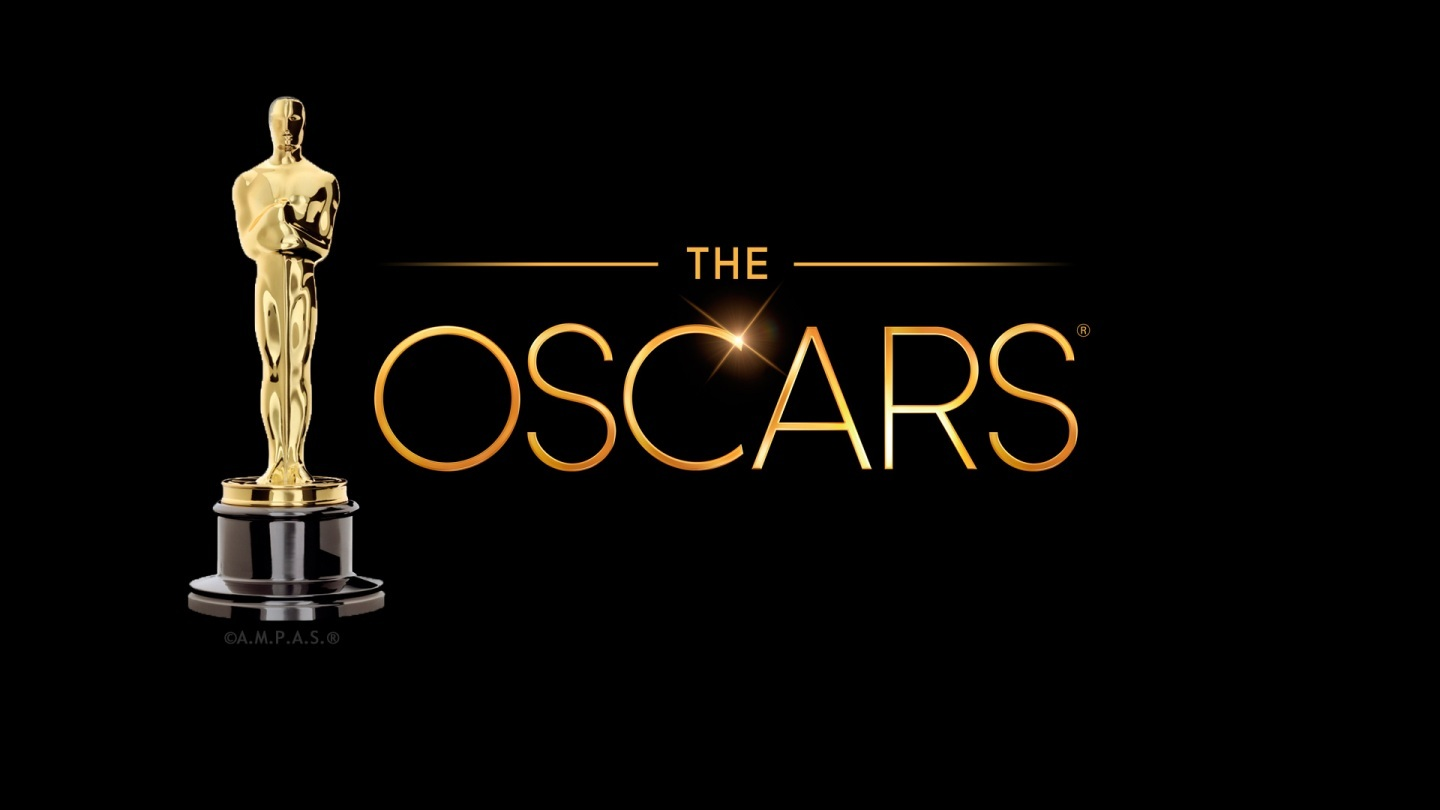

# Import Packages

In [2]:
import requests
from bs4 import BeautifulSoup
import pprint as p
import pandas as pd
import numpy as np
import re
pd.options.display.max_columns = None
from selenium import webdriver
import time
from selenium.webdriver.common.by import By
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline



# Web Scraping

## IMDB
<li> from 2000 till 2018

### Scraping Function for IMDB

In [13]:
def get_url_data(url):
    response = requests.get(url)
    #response = requests.get("https://www.imdb.com/search/title?title_type=feature&release_date=2017-01-01,2017-12-31&countries=us&languages=en&sort=num_votes,desc&count=250&start=251&ref_=adv_nxt")
    html_soup = BeautifulSoup(response.content,"lxml")


    ### 1st page only
    movie_containers = html_soup.find_all('div', {'class':'lister-item mode-advanced'})
    print(len(movie_containers))
    movie_dict = get_data(movie_containers)
    imdb_1 = pd.DataFrame(movie_dict)
    imdb_2 = imdb_1


    ### next page url
    from time import sleep
    from random import randint
    url = True
    i = 1
    while url:
        i = i + 1
        next_page_url = "https://www.imdb.com"+ (html_soup.find('a', {'class':'lister-page-next next-page'}).get('href') if html_soup.find('a', {'class':'lister-page-next next-page'}) else False)
        print(next_page_url)
        # keep first 5 page only can increase it.
        if i == 5:
            url = False
        sleep(randint(1,30))    
        response = requests.get(next_page_url)
        html_soup = BeautifulSoup(response.content,"lxml")
        movie_containers = html_soup.find_all('div', {'class':'lister-item mode-advanced'})
        print(len(movie_containers))
        movie_dict = get_data(movie_containers)
        imdb_1 = pd.DataFrame(movie_dict)
        imdb_2 = imdb_2.append(imdb_1, ignore_index=True)
    
    return imdb_2     
  

### Pick up the important variables from IMDB

In [14]:
def get_data(movie_containers):
    movie_dict = {'movie_name':[], 'year':[], 'runtime':[], 'certificate':[], 'genre':[], 
                  'imdb_rating':[], 'metascore':[], 'director':[], 'actors':[], 
                  'imdb_votes':[], 'us_box_office':[], 'summary':[] }
    for first_movie in movie_containers:
        movie_dict['movie_name'].append(first_movie.find('h3').find('a').get_text() if first_movie.find('h3').find('a') else None)
        movie_dict['year'].append(first_movie.find('h3').find('span', {'class':'lister-item-year text-muted unbold'}).get_text() if first_movie.find('h3').find('span', {'class':'lister-item-year text-muted unbold'}) else None)
        movie_dict['runtime'].append(first_movie.find('p').find('span', class_='runtime').get_text() if first_movie.find('p').find('span', class_='runtime') else None)
        
        if first_movie.find('p').find('span', {'class':'certificate'}) is not None:
            movie_dict['certificate'].append(first_movie.find('p').find('span', {'class':'certificate'}).get_text())
        else:
            movie_dict['certificate'].append(None)
        
        movie_dict['genre'].append(first_movie.find('p').find('span', {'class':'genre'}).get_text().split() if first_movie.find('p').find('span', {'class':'genre'}) else None)
        
        movie_dict['imdb_rating'].append(first_movie.find('div', {'class':'inline-block ratings-imdb-rating'}).find('strong').get_text() if first_movie.find('div', {'class':'inline-block ratings-imdb-rating'}) else None)
        
        if first_movie.find('div', class_ = 'ratings-metascore') is not None:
            movie_dict['metascore'].append(first_movie.find('div', {'class':'inline-block ratings-metascore'}).find('span').get_text().strip())
        else:
            movie_dict['metascore'].append(None)
        directors = []
        
        for i in first_movie.find_all('a'):
            if re.search('.*adv_li_dr.*', i.get('href')):
                directors.append(i.get_text())
        movie_dict['director'].append(directors)

        actors = []
        for i in first_movie.find_all('a'):
            if re.search('.*adv_li_st.*', i.get('href')):
                actors.append(i.get_text())
        movie_dict['actors'].append(actors)
        movie_dict['imdb_votes'].append(first_movie.find_all('span', {'name':'nv'})[0].get('data-value') if first_movie.find_all('span', {'name':'nv'}) else None    )
        if len(first_movie.find_all('span', {'name':'nv'})) > 1:
            movie_dict['us_box_office'].append(first_movie.find_all('span', {'name':'nv'})[1].get('data-value'))
        else:
            movie_dict['us_box_office'].append(None)
        
        summ = list()
        if first_movie.find_all('p', {'class':'text-muted'}):
            #for i in first_movie.find_all('p', {'class':'text-muted'}):
            summ.append(first_movie.find_all('p', {'class':'text-muted'})[1].get_text())
        else:
            summ = ''
        movie_dict['summary'].append(summ)    
        #print(movie_dict)

    
    return movie_dict

### column template

In [15]:
### column template
COLUMN_NAMES = ['movie_name', 'year', 'runtime', 'certificate', 'genre', 'imdb_rating',
       'metascore', 'director', 'actors', 'imdb_votes', 'us_box_office', 'summary']
imdb_comb2 = pd.DataFrame(columns=COLUMN_NAMES)
imdb_comb2

,movie_name,year,runtime,certificate,genre,imdb_rating,metascore,director,actors,imdb_votes,us_box_office,summary


### Start Scraping ...

In [17]:

for year in range(2018,1999,-1):
    url = ("https://www.imdb.com/search/title?title_type=feature&release_date=%s&countries=us&languages=en&sort=num_votes,desc&count=250" %year)
    print(url)
    imdb_comb1 = get_url_data(url)
    imdb_comb2 = imdb_comb2.append(imdb_comb1, ignore_index=True)

### Create a pickle for IMDB

In [ ]:
imdb_comb2.to_pickle('imdb.pkl')

In [21]:
imdb_comb2 = pd.read_pickle('imdb.pkl')
imdb_comb2.head(3)

,movie_name,year,runtime,certificate,genre,imdb_rating,metascore,director,actors,imdb_votes,us_box_office,summary
0,Avengers: Infinity War,(2018),149 min,PG-13,"[Action,, Adventure,, Fantasy]",8.5,68,"[Anthony Russo, Joe Russo]","[Robert Downey Jr., Chris Hemsworth, Mark Ruff...",524072,"678,815,482",[\n The Avengers and their allies must be w...
1,Black Panther,(2018),134 min,PG-13,"[Action,, Adventure,, Sci-Fi]",7.4,88,[Ryan Coogler],"[Chadwick Boseman, Michael B. Jordan, Lupita N...",414530,"700,059,566","[\n After the death of his father, Prince T..."
2,Deadpool 2,(2018),119 min,R,"[Action,, Adventure,, Comedy]",7.8,66,[David Leitch],"[Ryan Reynolds, Josh Brolin, Morena Baccarin, ...",301043,"318,491,426",[\n Foul-mouthed mutant mercenary Wade Wils...


## The Numbers (Box Office)

### Column template

In [18]:
#budget_df = pd.DataFrame(budget_dict)
col_names = ['release_date', 'movie_name', 'budget', 'domestic_gross',
       'world_wide_gross']
budget_df = pd.DataFrame(columns=col_names)

### Function for scraping

In [ ]:
def get_budget_gross(list_tr):
    budget_dict = { 'release_date':[], 'movie_name':[], 'budget':[], 
                       'domestic_gross':[], 'world_wide_gross':[]}
    for tr in list_tr:

        try:
            x_list = tr.find_all('td', {'class':'data'})
            #budget_dict['num'].append(x_list[0].get_text())  ### number
            budget_dict['release_date'].append(tr.find('a').get_text())  ### date
            budget_dict['movie_name'].append(tr.find('b').find('a').get_text())   ### movie name
            budget_dict['budget'].append(x_list[1].get_text())  ### budget
            budget_dict['domestic_gross'].append(x_list[2].get_text())  ### domestic_gross
            budget_dict['world_wide_gross'].append(x_list[3].get_text())  ### worldwide gross

        except:
            continue
    
    
    print(budget_dict)
    return  budget_dict       

In [ ]:
for i in range(1, 5700, 100):
    url = (f"https://www.the-numbers.com/movie/budgets/all/{i}")
    print(url)
    response = requests.get(url)
    html_soup = BeautifulSoup(response.content,"lxml")
    list_tr = html_soup.find('table').find_all('tr')
    budget_dict = get_budget_gross(list_tr)
    budget_iter_df = pd.DataFrame(budget_dict)
    budget_df = budget_df.append(budget_iter_df, ignore_index=True)   
    sleep(randint(1,30))    


### convert Final data to a pickle

In [ ]:
budget_df.to_pickle('thenumbers.pkl')

In [22]:
budget_df = pd.read_pickle('thenumbers.pkl')

budget_df.head(5)

,release_date,movie_name,budget,domestic_gross,world_wide_gross
0,12/18/2009,Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,5/20/2011,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,5/1/2015,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
3,12/15/2017,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,764,784"
4,12/18/2015,Star Wars Ep. VII: The Force Awakens,"$306,000,000","$936,662,225","$2,053,311,220"


## Film Festival Premiers (Wikipedia) 
<li> from 2000 to 2018
<li> Toronto Int. Film Festival (TIFF)
<li> Venice Film Festival
<li> Sundance Film Festival   
<li> Source - Wikipedia

### Toronto Film Festival (TIFF)

#### Column Header

In [24]:
col = ['Award', 'Film', 'Director', 'year']
pd_table1_final = pd.DataFrame(columns = col)
pd_table1_final.head()

,Award,Film,Director,year


#### Function for scraping

In [ ]:
### get winners
for i in range(2008,2019):
    url = f'https://en.wikipedia.org/wiki/{i}_Toronto_International_Film_Festival'
    print(url)
    x = pd.read_html(url, flavor = 'bs4', header = 0)
    pd_table1 = x[1]
    pd_table1.rename(columns={ pd_table1.columns[0]: "Award", pd_table1.columns[1]: "Film", 
                              pd_table1.columns[2]: "Director" }, inplace= True)
    pd_table1['year'] = i
    print(pd_table1.head())
    pd_table1_final = pd_table1_final.append(pd_table1, ignore_index=True)

In [25]:
### Function to get all premiers at TIFF
def get_list(ul_tags):
    ### 1st loop
    any_thing_list = list()
    for i_tags in ul_tags:
        try:
            any_thing_list.append(i_tags.find_all('li'))


        except:    
            continue

    ### 2nd loop go again        
    any_thing_list_1 = list()

    for i_tags1 in any_thing_list:
        for i_tags2 in i_tags1:
            try:
                #print(i_tags2.find_all('i'), len(i_tags2.find_all('i')))
                any_thing_list_1.append(i_tags2.find_all('i')) if len(i_tags2.find_all('i')) != 0 else "hey"
            except:
                continue   


    ### remove multiple lists
    any_thing_list_2 = list()
    any_thing_list_2.extend([j for i in any_thing_list_1 for j in i]) 


    ### Final List
    final_list = list()
    for i in any_thing_list_2:
        try:
            final_list.append(i.find('a').get_text())
        except:
            continue
            
    return final_list       

In [ ]:
### get all premiers

col = ['film', 'year']
final_df = pd.DataFrame(columns=col)


for i in range(2000,2019):
    url = f'https://en.wikipedia.org/wiki/{i}_Toronto_International_Film_Festival'
    response = requests.get(url)
    html_soup = BeautifulSoup(response.content,"lxml")
    ul_tags = html_soup.find_all('ul')
    final_list = list()
    final_list = get_list(ul_tags)
    final_to_df = pd.DataFrame(final_list, columns=['film'])
    final_to_df['year'] = i
    final_df = final_df.append(final_to_df, ignore_index=True)

##### change to pickle

In [ ]:
final_df.to_pickle('tiff_premiers.pkl')
pd_table1_final.to_pickle('tiff_winners.pkl')

### Venice Film Festival

#### Column header

In [ ]:
### Column Headers

col = ['English title', 'Original title', 'Director(s)', 'Production country', 'year']
v_table_final = pd.DataFrame(columns=col)


#### Function for scraping

In [ ]:
year = 2019
for i in range(75,59, -1):
    try:
        if i in [72,62]:
            url = f'https://en.wikipedia.org/wiki/{i}nd_Venice_International_Film_Festival'
        elif i in [63,73]:
            url = f'https://en.wikipedia.org/wiki/{i}rd_Venice_International_Film_Festival'
        else:        
            url = f'https://en.wikipedia.org/wiki/{i}th_Venice_International_Film_Festival'
        print(url)
        year -= 1
        x = pd.read_html(url, flavor = 'bs4', header = 0)
        v_table1 = x[1]
        v_table1.append(x[2])
        v_table1['year'] = year
        v_table_final = v_table_final.append(v_table1)
    except:
        continue

In [ ]:
col = ['film', 'year']
venice_final_df = pd.DataFrame(columns=col)


In [ ]:
### check out years are not numbered
year = 2019
for i in range(75,59, -1):
    try:
        if i in [72,62]:
            url = f'https://en.wikipedia.org/wiki/{i}nd_Venice_International_Film_Festival'
        elif i in [63,73]:
            url = f'https://en.wikipedia.org/wiki/{i}rd_Venice_International_Film_Festival'
        else:        
            url = f'https://en.wikipedia.org/wiki/{i}th_Venice_International_Film_Festival'
        print(url)
        year -= 1

        response = requests.get(url)
        html_soup = BeautifulSoup(response.content,"lxml")
        ul_tags = html_soup.find_all('ul')
        venice_final_list = list()
        venice_final_list = get_list(ul_tags)
        venice_final_to_df = pd.DataFrame(venice_final_list, columns=['film'])
        #print("Year", year)
        venice_final_to_df['year'] = year
        print(venice_final_to_df.head())
        venice_final_df = venice_final_df.append(venice_final_to_df, ignore_index=True)
    except:
        continue

In [ ]:
v_table_final.to_pickle('venice_premiers.pkl')
venice_final_df.to_pickle('venice_premiers.pkl')

### Sundance Film Festival

#### Column Header

In [ ]:
col = ['film', 'year']
sun_final_df = pd.DataFrame(columns=col)


#### Scraping Function

In [ ]:
for i in range(2006,2019):
    url = f'https://en.wikipedia.org/wiki/{i}Sundance_Film_Festival'
    response = requests.get(url)
    html_soup = BeautifulSoup(response.content,"lxml")
    ul_tags = html_soup.find_all('ul')
    final_list = list()
    final_list = get_list(ul_tags)
    final_to_df = pd.DataFrame(final_list, columns=['film'])
    final_to_df['year'] = i
    sun_final_df = final_df.append(final_to_df, ignore_index=True)

In [ ]:
sun_final_df.to_pickle('sundance_premiers.pkl')

### Combine all 3 festival data into one

In [ ]:
sun_final_df['type'] = 'sun'
venice_final_df['type'] = 'ven'
final_df['type'] = 'tor'

In [ ]:
film_fest_all = pd.concat([sun_final_df,venice_final_df,final_df], ignore_index=True)
film_fest_all.drop_duplicates(subset=['film','year'],keep='first')

In [ ]:
film_fest.head()
film_fest.rename(columns={'film':'movie_name'}, inplace = True)
film_fest['year'] = film_fest['year'].astype(int)



### Clean movie name
<li> change to lower case
<li> Remove punctuations
<li> Remove Special characters


In [ ]:
film_fest.loc[:, 'movie_name'].replace(r'[^\w\s]','', inplace = True, regex=True)
film_fest.loc[:'movie_name'].replace(r'  ','', inplace = True, regex=True)
film_fest.loc[:'movie_name'].replace(r'â',' ', inplace = True, regex=True)
film_fest['movie_name'] = film_fest.loc[:'movie_name']['movie_name'].astype(str).str.lower()

### Final Film Festival Pickle

In [ ]:
film_fest.to_pickle('film_fest.pkl')


In [28]:
film_fest = pd.read_pickle('film_fest.pkl')
film_fest.head(5)

,movie_name,year,type
0,almost famous,2000,sun
1,best in show,2000,sun
2,bread and tulips,2000,sun
3,the contender,2000,sun
4,crouching tiger hidden dragon,2000,sun


## Rotten Tomatoes
<li> To get Audience and critics score
<li> Use Selenium as driver

### Set up Selenium

In [ ]:
url = "https://www.rottentomatoes.com/browse/dvd-streaming-all/"
### Joy Directory
driver = webdriver.PhantomJS(executable_path='/Users/yaunqiaoying/Downloads/phantomjs-2.1.1-macosx/bin/phantomjs',service_log_path='/Users/yaunqiaoying/Desktop/DA_project/ghostdriver.log')
driver.get(url)
html_data = driver.page_source.encode('utf-8')
page_num = 0
driver.find_element_by_css_selector('btn.view-icon.active').click() 
while page_num < 200:
    driver.find_element_by_css_selector('button.btn.btn-secondary-rt.mb-load-btn').click() 
    page_num += 1
    time.sleep(1)

html_data = driver.page_source.encode('utf-8')

### Function

In [ ]:
python_data = BeautifulSoup(html_data,'lxml')
list_tag= python_data.find_all('div',class_='mb-movie')
big_list=[]
for tag in list_tag:
    dict_movie=dict()
    try: 
        dict_movie['movie_name']=tag.find('h3',class_='movieTitle').get_text()
    except:
        dict_movie['movie_name']=np.NaN
    try:
        score_list=tag.find_all('span',class_='tMeterScore')
    except:
        continue
    try:
        dict_movie['audience_score']=score_list[0].get_text()
    except:
        dict_movie['audience_score']=np.NaN
    try:
        dict_movie['rotten_tomato_score']=score_list[1].get_text()
    except:
        dict_movie['rotten_tomato_score']=np.NaN
    big_list.append(dict_movie)
big_list

### Cleaning

In [ ]:
df = pd.DataFrame(big_list)
df= df.dropna()
df.set_index('movie_name',inplace=True)
df["audience_score"]=df["audience_score"].apply(lambda x: float(x.strip('%')))
df["rotten_tomato_score"]=df["rotten_tomato_score"].apply(lambda x: float(x.strip('%')))

df.info()

### Convert to Data Frame and Export

In [ ]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('NEW_Rotten_tomato_.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df.to_excel(writer, sheet_name='movie_info')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

### Get Extra Rotten tomato score for missing films
<li> Note: used from below

#### Add the code here

## Oscar Actors & Directors (CSV): 
<li> Actors
<li> Director
<li> Penalize by 1 point as they might have been nominated for best film too. Will remove biasness

In [32]:
oscars = pd.read_csv('oscar_data_csv.csv')

### For Actors

In [ ]:
oscar_group = oscars[(oscars['category'].isin(['ACTOR IN A SUPPORTING ROLE', 'ACTRESS IN A SUPPORTING ROLE',
                         'ACTRESS', 'ACTOR', 'ACTRESS IN A LEADING ROLE', 'ACTOR IN A LEADING ROLE'])) & (oscars['year'] <=2015)]

In [ ]:
oscar_actor_nom = oscar_group.groupby('entity',as_index=False)[['category']].count()
oscar_actor_nom.head()
### Subtract by 1
oscar_actor_nom['category'] = oscar_actor_nom['category'] - 1
oscar_actor_nom = oscar_actor_nom.query("category > 0")

oscar_actor_nom = oscar_actor_nom.rename(columns={'entity': 'actor', 'category':'count'})
oscar_actor_nom.to_pickle('oscar_actors.pkl')

### For Directors

In [ ]:
dir_ = pd.read_csv('directors_oscars.csv')
dir_.query('Year=="2014"')

#### remove first few rows - starts from year 1940
dir_ = dir_.loc[30:]

### make year int
dir_['Year'] = dir_['Year'].astype(int)

### correct the name - lower case and remove punctuations
dir_['entity'] = dir_.loc[:]['Name'].str.strip().str.replace(r'[^\w\s]','').str.lower()
dir_['entity'] = dir_.loc[:]['entity'].str.replace(r'  ',' ')



In [ ]:
### Count

oscar_dir_nom = dir_.groupby('Film',as_index=False)[['Name']].count()
oscar_dir_nom = oscar_dir_nom.rename(columns={'Film': 'director', 'Name':'count'})
oscar_dir_nom.to_pickle('oscar_dir.pkl')


Get IMDB data here for merge and actor counts

In [ ]:
#all_oscars = pd.read_pickle('working_ver1.pkl')
all_oscars = imdb_comb2

In [ ]:
all_oscars = all_oscars[['movie_name', 'director', 'actors', 'year']]

In [ ]:
all_oscars = all_oscars.join(pd.DataFrame(all_oscars['actors'].dropna().tolist(), columns = ['actor1', 'actor2', 'actor3', 'actor4']))


### Melt your data and keep one row for each prime actor in the movie

In [ ]:
all_oscars_act = all_oscars[['movie_name', 'actor1', 'actor2','actor3','actor4']]
all_oscars_act = pd.melt(all_oscars_act, id_vars='movie_name', value_vars=['actor1', 'actor2', 'actor3', 'actor4'])

all_oscars_act.head()

In [ ]:
all_oscars_act = all_oscars[['movie_name', 'actor1', 'actor2','actor3','actor4']]
all_oscars_act = pd.melt(all_oscars_act, id_vars='movie_name', value_vars=['actor1', 'actor2', 'actor3', 'actor4'])

all_oscars_act.fillna(0, inplace=True)
all_oscars_act.head()

all_oscars_act['binary_count_actor'] = all_oscars_act['actor_nom_count'].apply(lambda x: 0 if x == 0 else 1)

movie_oscar_count_act = all_oscars_act.groupby('movie_name',as_index=False)['binary_count_actor'].sum()
#oscar_act_count_overall = oscar_act_count_overall[oscar_dir_count['value'] != 0]
movie_oscar_count_act.head()
#oscar_dir_count.to_pickle('oscar_dir_count.pkl')

### For Director merge to the movie

In [ ]:
all_oscars_dir = all_oscars[['movie_name', 'director']]


all_oscars_dir = all_oscars_dir.merge(oscar_dir_nom, how='left', left_on='director', right_on='director')
all_oscars_dir = all_oscars_dir.rename(columns={'count': 'dir_nom_count'})

In [ ]:
all_oscars_dir.head()

all_oscars_dir.fillna(0, inplace=True)
all_oscars_dir.head()

all_oscars_dir['binary_count_dir'] = all_oscars_dir['dir_nom_count'] ###.apply(lambda x: 0 if x == 0 else 1)

movie_oscar_count_dir = all_oscars_dir.groupby('movie_name',as_index=False)['binary_count_dir'].sum()

movie_oscar_count_dir.head()


### Combine actor & director in one df for export

In [ ]:
movie_oscar_count = movie_oscar_count_dir.merge(movie_oscar_count_act, how = 'left')

movie_oscar_count
movie_oscar_count.to_pickle('movie_oscar_count.pkl')

In [36]:
movie_oscar_count = pd.read_pickle('movie_oscar_count.pkl')
movie_oscar_count.head(5)

,movie_name,binary_count_dir,binary_count_actor
0,cemetery,0.0,0
1,just a job,0.0,0
2,001 trolling,0.0,0
3,0s 1s,0.0,0
4,1,0.0,0


## Bafta & Golden Globes (Wiki)

### Bafta

In [34]:
### Best Film

def get_bafta(): 
    bafta_dict = dict()
    for year in range(19):
        if year == 18: #2018 special case: title changed from 'film' to 'best film'
            url = 'http://awards.bafta.org/award/2018/film/best-film'
        else:
            url = 'http://awards.bafta.org/award/'+ str(year+2000) + '/film/film'
            
        results_page = requests.get(url)
        try:
            soup = BeautifulSoup(results_page.content,'lxml')
        except:
            print("we didn't get back data correctly")
            
        win = soup.find('div', class_="yac-winner-title").get_text()
        win_ppl = [x.get_text() for x in soup.find('div', class_="yac-winner-list").find_all('li')]
        nom = [x.get_text() for x in soup.find_all('div', {'id':"yac-nominee-title"})]
        nom_ppl = []
        nom_ppl_result = soup.find_all('div', {'id':"yac-nominee-list"})
        for i in nom_ppl_result:
            ppl = [x.get_text() for x in i.find_all('li')]
            nom_ppl.append(ppl)
        win_result = [win, win_ppl]
        nom_result = []
        for i in range(len(nom)):
            nom_result.append((nom[i],nom_ppl[i]))
        bafta_dict[str(year+2000)] = [win_result, nom_result]
        
    return bafta_dict

### Golden Globe

#### Drama Picture


In [2]:
### Golden Globe Motion Picture Drama

def get_gg_drama(): 
    gg_drama_dict = dict()
    for pageindex in range(5):
        url = 'https://www.goldenglobes.com/winners-nominees/best-motion-picture-drama?page='+str(pageindex)
            
        results_page = requests.get(url)
        try:
            soup = BeautifulSoup(results_page.content,'lxml')
        except:
            print("we didn't get back data correctly")
            
        years = soup.find_all('h2', class_ = 'view-grouping-header')
        movies = soup.find_all('div', class_ = 'view-grouping-content')
        for i in range(4):
            year = years[i].find('span',class_ = 'date-display-single').get_text()
            nom= [x.get_text() for x in movies[i].find_all('div',class_ = 'primary-nominee')]
            win = nom [0] 
            gg_drama_dict[str(year)] = [win, nom]  
    return gg_drama_dict

#### Comedy Picture

In [40]:
### musical or comedy nominations

def get_gg_muscom(): 
    gg_muscom_dict = dict()
    for pageindex in range(5):
        url = 'https://www.goldenglobes.com/winners-nominees/best-motion-picture-musical-or-comedy?page='+str(pageindex)
            
        results_page = requests.get(url)
        try:
            soup = BeautifulSoup(results_page.content,'lxml')
        except:
            print("we didn't get back data correctly")
            
        years = soup.find_all('h2', class_ = 'view-grouping-header')
        movies = soup.find_all('div', class_ = 'view-grouping-content')
        for i in range(4):
            year = years[i].find('span',class_ = 'date-display-single').get_text()
            nom= [x.get_text() for x in movies[i].find_all('div',class_ = 'primary-nominee')]
            win = nom [0] 
            gg_muscom_dict[str(year)] = [win, nom]  
    return gg_muscom_dict

In [39]:
#workspace

url = 'http://awards.bafta.org/award/2018/film/best-film'
results_page = requests.get(url)
soup = BeautifulSoup(results_page.content,'lxml')
win = soup.find('div', class_="yac-winner-title").get_text()
win_ppl = [x.get_text() for x in soup.find('div', class_="yac-winner-list").find_all('li')]
nom = [x.get_text() for x in soup.find_all('div', {'id':"yac-nominee-title"})]
nom_ppl = []
nom_ppl_result = soup.find_all('div', {'id':"yac-nominee-list"})
for i in nom_ppl_result:
    ppl = [x.get_text() for x in i.find_all('li')]
    nom_ppl.append(ppl)
win_result = [win, win_ppl]
nom_result = []
for i in range(len(nom)):
    nom_result.append((nom[i],nom_ppl[i]))
print((win,win_ppl))
print(nom_result)

('Three Billboards Outside Ebbing, Missouri', ['Graham Broadbent', 'Pete Czernin', 'Martin McDonagh'])
[('Call Me by Your Name', ['Emilie Georges', 'Luca Guadagnino', 'Marco Morabito', 'Peter Spears']), ('Darkest Hour', ['Tim Bevan', 'Lisa Bruce', 'Eric Fellner', 'Anthony McCarten', 'Douglas Urbanski']), ('Dunkirk', ['Christopher Nolan', 'Emma Thomas']), ('The Shape of Water', ['Guillermo del Toro', 'J. Miles Dale']), ('Three Billboards Outside Ebbing, Missouri', ['Graham Broadbent', 'Pete Czernin', 'Martin McDonagh'])]


## Critics Choice Awards

### Create Function

In [ ]:
all_nomination=list()
for i in range(2000,2018):
    
    url="https://www.filmaffinity.com/en/awards.php?award_id=critics_choice_awards&year=%s" %(i)
    from bs4 import BeautifulSoup
    import requests
    page_soup = BeautifulSoup(requests.get(url).content,'lxml')
    nominee=page_soup.find_all('div',class_="aw-mc2 ")
    winner_name=page_soup.find_all('div',class_='aw-mc2 winner-border')
    for tag in winner_name:
        name=tag.find('a').get('title')
        winner=1
        year=url[-4:]
        all_nomination.append((name,winner,year))
    for tag in nominee:
        name=tag.find('a').get('title')
        winner=0
        year=url[-4:]
        all_nomination.append((name,winner,year))




### Convert to Pandas

In [ ]:
import numpy as np
import pandas as pd
fields = ['movie_name','winner','year']
table=pd.DataFrame(all_nomination,columns=fields)
#table.set_index('movie_name',inplace=True)
table.groupby(['year','winner']).count()
table.groupby(['year']).count()
table.groupby(['winner']).count()


## AFI Awards

### Create Function

In [41]:
nomination_AFI=list()
for i in range(2000,2018):
    url="https://www.filmaffinity.com/en/awards.php?award_id=afi&year=%s"%(i)
    from bs4 import BeautifulSoup
    import requests
    page_soup = BeautifulSoup(requests.get(url).content,'lxml')
    nominee=page_soup.find_all('div',class_="aw-mc2 ")
    for tag in nominee:
            name=tag.find('a').get('title')
            year=url[-4:]
            nomination_AFI.append((name,year))


,movie_name
year,
2000,10
2001,10
2002,10
2003,10
2004,10
2005,10
2006,10
2007,10
2008,10


### Convert to Pandas

In [ ]:
import numpy as np
import pandas as pd
fields = ['movie_name','year']
table_AFI=pd.DataFrame(nomination_AFI,columns=fields)
#table_AFI.set_index('movie_name',inplace=True)
#table_AFI.groupby(['year']).count()

# Data Cleaning & Preparation

## IMDB  (Main Data)

### Read Pickle

In [42]:
from_imdb = pd.read_pickle('imdb.pkl')

In [43]:
from_imdb.head()

,movie_name,year,runtime,certificate,genre,imdb_rating,metascore,director,actors,imdb_votes,us_box_office,summary
0,Avengers: Infinity War,(2018),149 min,PG-13,"[Action,, Adventure,, Fantasy]",8.5,68,"[Anthony Russo, Joe Russo]","[Robert Downey Jr., Chris Hemsworth, Mark Ruff...",524072,"678,815,482",[\n The Avengers and their allies must be w...
1,Black Panther,(2018),134 min,PG-13,"[Action,, Adventure,, Sci-Fi]",7.4,88,[Ryan Coogler],"[Chadwick Boseman, Michael B. Jordan, Lupita N...",414530,"700,059,566","[\n After the death of his father, Prince T..."
2,Deadpool 2,(2018),119 min,R,"[Action,, Adventure,, Comedy]",7.8,66,[David Leitch],"[Ryan Reynolds, Josh Brolin, Morena Baccarin, ...",301043,"318,491,426",[\n Foul-mouthed mutant mercenary Wade Wils...
3,Ready Player One,(2018),140 min,PG-13,"[Action,, Adventure,, Sci-Fi]",7.6,64,[Steven Spielberg],"[Tye Sheridan, Olivia Cooke, Ben Mendelsohn, L...",240721,"137,018,455",[\n When the creator of a virtual reality w...
4,A Quiet Place,(2018),90 min,PG-13,"[Drama,, Horror,, Mystery]",7.6,82,[John Krasinski],"[Emily Blunt, John Krasinski, Millicent Simmon...",230521,"188,024,361","[\n In a post-apocalyptic world, a family i..."


### Split genre in Cols 

In [48]:
x = from_imdb.copy()
x.head()
from_imdb = from_imdb.join(x.genre.apply(pd.Series).add_prefix('genre_'))
from_imdb.head(2)

,movie_name,year,runtime,certificate,genre,imdb_rating,metascore,director,actors,imdb_votes,us_box_office,summary,genre_0,genre_1,genre_2
0,Avengers: Infinity War,(2018),149 min,PG-13,"[Action,, Adventure,, Fantasy]",8.5,68,"[Anthony Russo, Joe Russo]","[Robert Downey Jr., Chris Hemsworth, Mark Ruff...",524072,"678,815,482",[\n The Avengers and their allies must be w...,"Action,","Adventure,",Fantasy
1,Black Panther,(2018),134 min,PG-13,"[Action,, Adventure,, Sci-Fi]",7.4,88,[Ryan Coogler],"[Chadwick Boseman, Michael B. Jordan, Lupita N...",414530,"700,059,566","[\n After the death of his father, Prince T...","Action,","Adventure,",Sci-Fi


In [49]:
### keep any removing rows here
from_imdb = from_imdb[from_imdb['year'] !='']  ### removed one row only
from_imdb = from_imdb[from_imdb['movie_name'] !='Safe House']  ### removed one row

### Remove punctuations, change to int/float

In [51]:
### year brackets and punctions and convert to int
from_imdb['year'] = from_imdb['year'].str.replace(r'\D+', '').astype(int)

### remove 'min' from runtime and change to int
### fillna with 0 for now
from_imdb['runtime'] = from_imdb['runtime'].str.replace(' min', '').str.strip().fillna(0).astype(int)

### change rating to float
from_imdb['imdb_rating'] = from_imdb['imdb_rating'].fillna(0).astype(float)

### change metascore to int
from_imdb['metascore'] = from_imdb['metascore'].fillna(0).astype(int)

### change imdb_votes to int
from_imdb['imdb_votes'] = from_imdb['imdb_votes'].str.replace(',', '').fillna(0).astype(int)

### change us_box_office to int
from_imdb['us_box_office'] = from_imdb['us_box_office'].str.replace(',', '').fillna(0).astype(int)


### convert summary from list to string and strip and remove '\n'
from_imdb['summary'] = from_imdb['summary'].apply(lambda x: "".join(x)).str.strip().replace("\n", "")

### remove ',' commas from genre
from_imdb['genre_0'] = from_imdb['genre_0'].str.replace(',', '')
from_imdb['genre_1'] = from_imdb['genre_1'].str.replace(',', '')
from_imdb['genre_2'] = from_imdb['genre_2'].str.replace(',', '')

### change box office to millions
from_imdb['us_box_office'] = from_imdb['us_box_office'].apply(lambda x: round(x/1000000))  ### millions

### remove list from director and join
from_imdb['director'] = from_imdb['director'].apply(lambda x: " ".join(x))

### Cap movie runtime 
<li> To 200 minutes and lower cap to 80 min

In [ ]:
from_imdb1['runtime'] = from_imdb1['runtime'].apply(lambda x: 200 if x > 200 else x)
#oscar_nom['runtime'] = oscar_nom['runtime'].apply(lambda x: 200 if x > 200 else x)


from_imdb1['runtime'] = from_imdb1['runtime'].apply(lambda x: 80 if x < 80 else x)
#oscar_nom['runtime'] = oscar_nom['runtime'].apply(lambda x: 80 if x < 80 else x)


## Merge oscar Nominated Films

In [53]:
oscar_raw_films = pd.read_csv('oscar_data_csv.csv')
oscar_raw_films.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11058 entries, 0 to 11057
Data columns (total 4 columns):
year        11058 non-null int64
category    11058 non-null object
winner      11058 non-null bool
entity      11058 non-null object
dtypes: bool(1), int64(1), object(2)
memory usage: 270.0+ KB


### filter for best picture and year >= 2000

In [54]:
oscar_raw_films_2000s = oscar_raw_films[(oscar_raw_films['category'] == 'BEST PICTURE') & (oscar_raw_films['year']>2000)]

### Merge with Main data

In [55]:
### merge with main df
from_imdb1 =  from_imdb.merge(oscar_raw_films_2000s[['entity','winner']], left_on='movie_name', right_on='entity', how = 'left')
#from_imdb1.drop('year_y', inplace=True, axis = 1)

In [56]:
### Fill NA with NA
from_imdb1['entity'] = from_imdb1['entity'].fillna('NA')

from_imdb1['oscar_nom'] = from_imdb1['entity'].apply(lambda x: 0 if x == 'NA' else 1)

### Clean Movie Name. 
<li> Change to lowercase
<li> Strip any special characters

In [58]:
from_imdb1['movie_name'] = from_imdb1.loc[:]['movie_name'].str.replace(r'[^\w\s]','').str.lower()
from_imdb1['movie_name'] = from_imdb1.loc[:]['movie_name'].str.replace(r'  ',' ')
# from_imdb1['movie_name'] = from_imdb1.loc[:]['movie_name'].str.replace(r'â',' ')

from_imdb1.head(5)


,movie_name,year,runtime,certificate,genre,imdb_rating,metascore,director,actors,imdb_votes,us_box_office,summary,genre_0,genre_1,genre_2,entity,winner,oscar_nom
0,avengers infinity war,2018,149,PG-13,"[Action,, Adventure,, Fantasy]",8.5,68,Anthony Russo Joe Russo,"[Robert Downey Jr., Chris Hemsworth, Mark Ruff...",524072,679,The Avengers and their allies must be willing ...,Action,Adventure,Fantasy,NA,NaN,0
1,black panther,2018,134,PG-13,"[Action,, Adventure,, Sci-Fi]",7.4,88,Ryan Coogler,"[Chadwick Boseman, Michael B. Jordan, Lupita N...",414530,700,"After the death of his father, Prince T'Challa...",Action,Adventure,Sci-Fi,NA,NaN,0
2,deadpool 2,2018,119,R,"[Action,, Adventure,, Comedy]",7.8,66,David Leitch,"[Ryan Reynolds, Josh Brolin, Morena Baccarin, ...",301043,318,Foul-mouthed mutant mercenary Wade Wilson (AKA...,Action,Adventure,Comedy,NA,NaN,0
3,ready player one,2018,140,PG-13,"[Action,, Adventure,, Sci-Fi]",7.6,64,Steven Spielberg,"[Tye Sheridan, Olivia Cooke, Ben Mendelsohn, L...",240721,137,When the creator of a virtual reality world ca...,Action,Adventure,Sci-Fi,NA,NaN,0
4,a quiet place,2018,90,PG-13,"[Drama,, Horror,, Mystery]",7.6,82,John Krasinski,"[Emily Blunt, John Krasinski, Millicent Simmon...",230521,188,"In a post-apocalyptic world, a family is force...",Drama,Horror,Mystery,NA,NaN,0


## Merge Box Office Data
### Clean Numbers

In [62]:
numbers = pd.read_pickle('thenumbers.pkl')


### change budget to int and convert to millions
numbers['budget'] = numbers['budget'].str.replace(r'[$,]', "").astype(int)
numbers['budget'] = numbers['budget'].apply(lambda x: round(x/1000000))

### change domestic_gross to int and convert to millions
numbers['domestic_gross'] = numbers['domestic_gross'].str.replace(r'[$,]', "").astype(int)
numbers['domestic_gross'] = numbers['domestic_gross'].apply(lambda x: round(x/1000000))

### change world_wide_gross to int and convert to millions
numbers['world_wide_gross'] = numbers['world_wide_gross'].str.replace(r'[$,]', "").astype(int)
numbers['world_wide_gross'] = numbers['world_wide_gross'].apply(lambda x: round(x/1000000))


### convert release_date to date
numbers['release_date'] = pd.to_datetime(numbers['release_date'])

### Clean movie name

In [63]:
numbers.loc[:, 'movie_name'].replace(r'[^\w\s]','', inplace = True, regex=True)
numbers.loc[:'movie_name'].replace(r'  ','', inplace = True, regex=True)
numbers.loc[:'movie_name'].replace(r'â',' ', inplace = True, regex=True)
numbers['movie_name'] = numbers.loc[:'movie_name']['movie_name'].astype(str).str.lower()
#numbers.loc[numbers['movie_name'].str.contains('Mission')]['movie_name']

### Merge

In [64]:
from_imdb1 = from_imdb1.merge(numbers, left_on = 'movie_name', right_on='movie_name', how='left')

In [65]:
from_imdb1.to_pickle('from_imdb1.pkl')

## Merge Oscar Count Actors/Directors

### Read Pickle

In [66]:
movie_oscar_count = pd.read_pickle('movie_oscar_count.pkl')
from_imdb1 = from_imdb1.merge(movie_oscar_count, how='left', left_on='movie_name', right_on='movie_name')

#### Fill missing month with - "0"
from_imdb1['release_month'] = from_imdb1['release_date'].apply(lambda x: x.month).fillna(0).astype(int)

In [67]:
from_imdb1.head(5)

,movie_name,year,runtime,certificate,genre,imdb_rating,metascore,director,actors,imdb_votes,us_box_office,summary,genre_0,genre_1,genre_2,entity,winner,oscar_nom,release_date,budget,domestic_gross,world_wide_gross,binary_count_dir,binary_count_actor,release_month
0,avengers infinity war,2018,149,PG-13,"[Action,, Adventure,, Fantasy]",8.5,68,Anthony Russo Joe Russo,"[Robert Downey Jr., Chris Hemsworth, Mark Ruff...",524072,679,The Avengers and their allies must be willing ...,Action,Adventure,Fantasy,NA,NaN,0,2018-04-27,300.0,679.0,2008.0,0.0,2,4
1,black panther,2018,134,PG-13,"[Action,, Adventure,, Sci-Fi]",7.4,88,Ryan Coogler,"[Chadwick Boseman, Michael B. Jordan, Lupita N...",414530,700,"After the death of his father, Prince T'Challa...",Action,Adventure,Sci-Fi,NA,NaN,0,2018-02-16,200.0,700.0,1347.0,0.0,0,2
2,deadpool 2,2018,119,R,"[Action,, Adventure,, Comedy]",7.8,66,David Leitch,"[Ryan Reynolds, Josh Brolin, Morena Baccarin, ...",301043,318,Foul-mouthed mutant mercenary Wade Wilson (AKA...,Action,Adventure,Comedy,NA,NaN,0,2018-05-18,110.0,318.0,734.0,0.0,0,5
3,ready player one,2018,140,PG-13,"[Action,, Adventure,, Sci-Fi]",7.6,64,Steven Spielberg,"[Tye Sheridan, Olivia Cooke, Ben Mendelsohn, L...",240721,137,When the creator of a virtual reality world ca...,Action,Adventure,Sci-Fi,NA,NaN,0,2018-03-29,150.0,137.0,579.0,7.0,0,3
4,a quiet place,2018,90,PG-13,"[Drama,, Horror,, Mystery]",7.6,82,John Krasinski,"[Emily Blunt, John Krasinski, Millicent Simmon...",230521,188,"In a post-apocalyptic world, a family is force...",Drama,Horror,Mystery,NA,NaN,0,2018-04-06,17.0,188.0,335.0,0.0,0,4


## Merge Film Festival

In [68]:
film_fest = pd.read_pickle('film_fest.pkl')
from_imdb1 = from_imdb1.merge(film_fest, how='left', left_on=['movie_name'], right_on=['movie_name'])

### Fill na with "0"
from_imdb1['film_fes'] = from_imdb1['type'].fillna(0).apply(lambda x: 1 if x != 0 else 0)

In [69]:
### drop similar name columns
from_imdb1.drop(columns=['type','year_y'], inplace=True)
from_imdb1.rename(columns={'year_x':'year'},inplace=True)

## Profit Percentage of Box Office

In [70]:
### round it to integer

from_imdb1['per_change_dom'] = round(((from_imdb1['domestic_gross'] - from_imdb1['budget'])/from_imdb1['budget']) * 100)

from_imdb1['per_change_all'] = round(((from_imdb1['world_wide_gross'] - from_imdb1['budget'])/from_imdb1['budget']) * 100)


### covert infinity to 0
from_imdb1['per_change_dom'].replace(np.inf, 0, inplace=True)
from_imdb1['per_change_all'].replace(np.inf, 0, inplace=True)


## Change year to Integer

In [71]:
from_imdb1['year'] = from_imdb1['year'].astype(int)

## Clean duplicate based on movie,year and imdb rating level

In [73]:
### check duplicates
from_imdb1[from_imdb1.duplicated(subset=['movie_name', 'year', 'imdb_rating'], keep=False)].sort_values(
    by='movie_name')

### remove duplicates
from_imdb1.drop_duplicates(subset=['movie_name', 'year', 'imdb_rating'], inplace=True)

In [74]:
### check again
from_imdb1[from_imdb1.duplicated(subset=['movie_name', 'year', 'imdb_rating'], keep=False)].sort_values(
    by='movie_name')

,movie_name,year,runtime,certificate,genre,imdb_rating,metascore,director,actors,imdb_votes,us_box_office,summary,genre_0,genre_1,genre_2,entity,winner,oscar_nom,release_date,budget,domestic_gross,world_wide_gross,binary_count_dir,binary_count_actor,release_month,film_fes,per_change_dom,per_change_all


In [100]:
from_imdb_4 = from_imdb1

## Merge Rotten Tomato

In [101]:
rt = pd.read_excel('new_Rotten_tomato_.xlsx')

#### clean the name
rt['movie_name'] = rt.loc[:]['movie_name'].str.replace(r'[^\w\s]','').str.lower()

### check duplicates
rt[rt.duplicated(subset=['movie_name'], 
                                 keep=False)].sort_values(by=['movie_name', 'rotten_tomato_score'],
                                                         ascending=[True, False])


### remove duplicate names
rt.drop_duplicates(subset=['movie_name'],keep='first', inplace = True)

In [102]:
from_imdb_4 = from_imdb_4.merge(rt, how = 'left', left_on = 'movie_name', right_on = 'movie_name')

In [103]:
### rename columns

from_imdb_4.rename(columns={'audience_score':'rt_aud_score', 'rotten_tomato_score':'rt_crtics_score'}, inplace=True)

## Merge Bafta and Critics Awards Data

In [106]:
bafta = pd.read_pickle('Final_Unique_datset.pkl')
bafta.head()


from_imdb_4 = from_imdb_4.merge(bafta[['movie_name', 'year', 'winner_cc_award', 'year_cc_award', 'movie_name_cc', 
                       'nomination_cc', 'bafta_award']], how = 'left', left_on = ['movie_name', 'year'], 
                  right_on= ['movie_name', 'year'])

### drop duplicates
from_imdb_4.drop_duplicates(subset=['movie_name', 'year', 'imdb_rating'], inplace=True)

### drop extra columns
from_imdb_4.drop(columns=['winner_cc_award', 'year_cc_award', 'movie_name_cc'], inplace=True)


# ### change to string
from_imdb_4['bafta_award']  = from_imdb_4['bafta_award'].astype(int).astype(str)
from_imdb_4['nomination_cc']  = from_imdb_4['nomination_cc'].astype(int).astype(str)

In [114]:
### get release month
rel_final = pd.read_pickle('rel_final.pkl')
rel_final.head(2)
rel_final.query('movie_name.str.lower().str.contains("avenger")', engine='python')
from_imdb_4 = from_imdb_4.merge(rel_final, how = 'left', left_on=['movie_name', 'year'], right_on=['movie_name', 'year'])

## Create Dummy variables - Genre

In [ ]:
from_imdb_4['genre_all'] = from_imdb_4['genre_0'].fillna('') + "," + from_imdb_4['genre_1'].fillna('') + "," + from_imdb_4['genre_2'].fillna('')


dummy_gen = from_imdb_4.genre_all.str.get_dummies(',')

from_imdb_4 = from_imdb_4.merge(dummy_gen, how = 'inner', left_index=True, 
                                right_index = True)

### change music and musical to one

from_imdb_4.loc[from_imdb_4['Music'] == 1, 'Musical'] = from_imdb_4['Music']
from_imdb_4.drop(columns='Music', inplace=True)

In [105]:
from_imdb_4.head(5)

,movie_name,year,runtime,certificate,genre,imdb_rating,metascore,director,actors,imdb_votes,us_box_office,summary,genre_0,genre_1,genre_2,entity,winner,oscar_nom,release_date,budget,domestic_gross,world_wide_gross,binary_count_dir,binary_count_actor,release_month,film_fes,per_change_dom,per_change_all,rt_aud_score,rt_crtics_score,genre_all,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Thriller,War,Western
0,avengers infinity war,2018,149,PG-13,"[Action,, Adventure,, Fantasy]",8.5,68,Anthony Russo Joe Russo,"[Robert Downey Jr., Chris Hemsworth, Mark Ruff...",524072,679,The Avengers and their allies must be willing ...,Action,Adventure,Fantasy,NA,NaN,0,2018-04-27,300.0,679.0,2008.0,0.0,2,4,0,126.0,569.0,84.0,91.0,"Action,Adventure,Fantasy",1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,black panther,2018,134,PG-13,"[Action,, Adventure,, Sci-Fi]",7.4,88,Ryan Coogler,"[Chadwick Boseman, Michael B. Jordan, Lupita N...",414530,700,"After the death of his father, Prince T'Challa...",Action,Adventure,Sci-Fi,NA,NaN,0,2018-02-16,200.0,700.0,1347.0,0.0,0,2,0,250.0,574.0,97.0,79.0,"Action,Adventure,Sci-Fi",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,deadpool 2,2018,119,R,"[Action,, Adventure,, Comedy]",7.8,66,David Leitch,"[Ryan Reynolds, Josh Brolin, Morena Baccarin, ...",301043,318,Foul-mouthed mutant mercenary Wade Wilson (AKA...,Action,Adventure,Comedy,NA,NaN,0,2018-05-18,110.0,318.0,734.0,0.0,0,5,0,189.0,567.0,83.0,85.0,"Action,Adventure,Comedy",1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,ready player one,2018,140,PG-13,"[Action,, Adventure,, Sci-Fi]",7.6,64,Steven Spielberg,"[Tye Sheridan, Olivia Cooke, Ben Mendelsohn, L...",240721,137,When the creator of a virtual reality world ca...,Action,Adventure,Sci-Fi,NA,NaN,0,2018-03-29,150.0,137.0,579.0,7.0,0,3,0,-9.0,286.0,72.0,77.0,"Action,Adventure,Sci-Fi",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,a quiet place,2018,90,PG-13,"[Drama,, Horror,, Mystery]",7.6,82,John Krasinski,"[Emily Blunt, John Krasinski, Millicent Simmon...",230521,188,"In a post-apocalyptic world, a family is force...",Drama,Horror,Mystery,NA,NaN,0,2018-04-06,17.0,188.0,335.0,0.0,0,4,0,1006.0,1871.0,95.0,83.0,"Drama,Horror,Mystery",0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0


#### List of Columns 

In [115]:
from_imdb_4.columns


Index(['movie_name', 'year', 'runtime', 'certificate', 'genre', 'imdb_rating',
       'metascore', 'director', 'actors', 'imdb_votes', 'us_box_office',
       'summary', 'genre_0', 'genre_1', 'genre_2', 'entity', 'winner',
       'oscar_nom', 'release_date', 'budget', 'domestic_gross',
       'world_wide_gross', 'binary_count_dir', 'binary_count_actor',
       'release_month', 'film_fes', 'per_change_dom', 'per_change_all',
       'rt_aud_score', 'rt_crtics_score', 'genre_all', 'Action', 'Adventure',
       'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family',
       'Fantasy', 'History', 'Horror', 'Musical', 'Mystery', 'News',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War',
       'Western', 'nomination_cc', 'bafta_award', 'month_num'],
      dtype='object')

## Change orders of columns

In [116]:
from_imdb_5 = from_imdb_4[['movie_name', 'year', 'runtime', 'certificate', 'genre',
       'imdb_rating', 'metascore', 'director', 'actors', 'imdb_votes',
       'us_box_office', 'summary',  'oscar_nom',
    'budget', 'domestic_gross', 'world_wide_gross',
       'film_fes', 'per_change_dom', 'per_change_all', 'rt_aud_score',
       'rt_crtics_score', 'nomination_cc', 'bafta_award', 
       
             'genre_all', 'Action', 'Adventure', 'Animation',
       'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy',
       'History', 'Horror', 'Musical', 'Mystery', 'News', 'Reality-TV',
       'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western', 'release_date', 'month_num'
       ]]

In [119]:
### get extra RT score
extra_rt = pd.read_pickle('rotten_tomato_clean.pkl')

from_imdb_5 = from_imdb_5.merge(extra_rt[['movie_name','meter_score', 'audience_score']], how='left', 
                           left_on='movie_name', right_on='movie_name')

from_imdb_5['rt_crtics_score'] = np.where(from_imdb_5['rt_crtics_score'].isnull(), 
                                          from_imdb_5['meter_score'],from_imdb_5['rt_crtics_score'])
from_imdb_5['rt_aud_score'] = np.where(from_imdb_5['rt_aud_score'].isnull(), 
                                       from_imdb_5['audience_score'],from_imdb_5['rt_aud_score']  )


### drop some columns
from_imdb_5.drop(columns=['meter_score','audience_score'], inplace=True)

### rename column
from_imdb_5.rename(columns={'release_date_x':'release_date'}, inplace=True)

In [124]:
from_imdb_5.to_pickle('clean_ver_1.pkl')

from_imdb_6 = pd.read_pickle('clean_ver_1.pkl')

In [126]:
from_imdb_6.head(2)

,movie_name,year,runtime,certificate,genre,imdb_rating,metascore,director,actors,imdb_votes,us_box_office,summary,oscar_nom,budget,domestic_gross,world_wide_gross,film_fes,per_change_dom,per_change_all,rt_aud_score,rt_crtics_score,nomination_cc,bafta_award,genre_all,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Thriller,War,Western,release_date,month_num
0,avengers infinity war,2018,149,PG-13,"[Action,, Adventure,, Fantasy]",8.5,68,Anthony Russo Joe Russo,"[Robert Downey Jr., Chris Hemsworth, Mark Ruff...",524072,679,The Avengers and their allies must be willing ...,0,300.0,679.0,2008.0,0,126.0,569.0,84.0,91.0,0,0,"Action,Adventure,Fantasy",1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2018-04-27,4.0
1,black panther,2018,134,PG-13,"[Action,, Adventure,, Sci-Fi]",7.4,88,Ryan Coogler,"[Chadwick Boseman, Michael B. Jordan, Lupita N...",414530,700,"After the death of his father, Prince T'Challa...",0,200.0,700.0,1347.0,0,250.0,574.0,97.0,79.0,0,0,"Action,Adventure,Sci-Fi",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2018-02-16,2.0


## Penalize Director count
<li> subtract/penalize oscar actor(done during scrapping) and director by 1 as it could be same year

In [127]:
#from_imdb_6.drop(columns=['binary_count_actor','binary_count_dir'], inplace=True)


movie_oscar_count = pd.read_pickle('movie_oscar_count.pkl')
movie_oscar_count.head()
movie_oscar_count.query('movie_name.str.lower().str.contains("shutter")', engine='python') 


from_imdb_6 = from_imdb_6.merge(movie_oscar_count, how='left', left_on='movie_name', right_on='movie_name')

In [128]:
from_imdb_6['binary_count_dir'] = from_imdb_6['binary_count_dir'] -1


from_imdb_6['binary_count_dir'] = from_imdb_6['binary_count_dir'].apply(lambda x: 0 if x <0 else x)


### manual change director coean
from_imdb_6.loc[from_imdb_6['movie_name'] == 'Ethan Coen Joel Coen', 'binary_count_dir'] = 1

from_imdb_6['bafta_award'] = from_imdb_6['bafta_award'].astype('float').astype(int)
from_imdb_6['nomination_cc'] = from_imdb_6['nomination_cc'].astype('float').astype(int)

In [129]:
from_imdb_6.to_pickle('clean_ver_2.pkl')

In [130]:
### get extra rotten tomato data for some films that are required in final data set

### month string to integer change function
def month_converter(month):
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '', ' ', 'nan', np.nan
             ]
    return months.index(month) + 1

### get data for missing variable
miss_rt = pd.read_csv('missing_data.csv')
x = miss_rt.release_date.str.split(" ", expand = True)
x.rename(columns={0:'month', 1:'date'}, inplace=True)

x['month_num'] = x['month'].apply(month_converter)

### merge with missing data
miss_rt = miss_rt.merge(x, how = 'left', right_index=True, left_index=True )

miss_rt = miss_rt.query("month_num<=12")

miss_rt['movie_name'] = miss_rt['movie_name'].str.replace("_", " ")


### merge to main data
from_imdb_6 = from_imdb_6.merge(miss_rt[['movie_name','rt_crtics_score', 'month_num']], 
                  how = 'left', left_on = 'movie_name', right_on = 'movie_name')


from_imdb_6['rt_crtics_score_x'] = np.where(from_imdb_6['rt_crtics_score_x'].isnull(), 
                                          from_imdb_6['rt_crtics_score_y'],from_imdb_6['rt_crtics_score_x'])

from_imdb_6['month_num_x'] = np.where(from_imdb_6['month_num_x'].isnull(), 
                                          from_imdb_6['month_num_y'],from_imdb_6['month_num_x'])


from_imdb_6.drop(columns=['rt_crtics_score_y', 'month_num_y' ],inplace=True )


from_imdb_6.rename(columns={'rt_crtics_score_x':'rt_crtics_score', 'month_num_x':'month_num'}, inplace=True)

In [133]:
### Final Columns
from_imdb_7 = from_imdb_6[['movie_name', 'year', 'runtime', 'certificate', 'genre', 'imdb_rating',
       'metascore', 'director', 'actors', 'imdb_votes', 'us_box_office',
       'summary', 'oscar_nom', 'budget', 'domestic_gross', 'world_wide_gross',
       'film_fes', 'per_change_dom', 'per_change_all', 
       'rt_crtics_score', 'nomination_cc', 'bafta_award', 'genre_all',
       'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Musical', 'Mystery',
       'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War',
       'Western', 'release_date', 'month_num', 'binary_count_dir',
       'binary_count_actor']]

## Do not run during the presentations

In [ ]:
from_imdb_7.to_pickle("clean_ver_3.pkl")

## Final Data Layout

In [135]:
from_imdb_7 = pd.read_pickle("clean_ver_3.pkl")


from_imdb_7.head(5)

,movie_name,year,runtime,certificate,genre,imdb_rating,metascore,director,actors,imdb_votes,us_box_office,summary,oscar_nom,budget,domestic_gross,world_wide_gross,film_fes,per_change_dom,per_change_all,rt_crtics_score,nomination_cc,bafta_award,genre_all,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Thriller,War,Western,release_date,month_num,binary_count_dir,binary_count_actor
0,avengers infinity war,2018,149,PG-13,"[Action,, Adventure,, Fantasy]",8.5,68,Anthony Russo Joe Russo,"[Robert Downey Jr., Chris Hemsworth, Mark Ruff...",524072,679,The Avengers and their allies must be willing ...,0,300.0,679.0,2008.0,0,126.0,569.0,91.0,0,0,"Action,Adventure,Fantasy",1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2018-04-27,4.0,0.0,2
1,black panther,2018,134,PG-13,"[Action,, Adventure,, Sci-Fi]",7.4,88,Ryan Coogler,"[Chadwick Boseman, Michael B. Jordan, Lupita N...",414530,700,"After the death of his father, Prince T'Challa...",0,200.0,700.0,1347.0,0,250.0,574.0,79.0,0,0,"Action,Adventure,Sci-Fi",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2018-02-16,2.0,0.0,0
2,deadpool 2,2018,119,R,"[Action,, Adventure,, Comedy]",7.8,66,David Leitch,"[Ryan Reynolds, Josh Brolin, Morena Baccarin, ...",301043,318,Foul-mouthed mutant mercenary Wade Wilson (AKA...,0,110.0,318.0,734.0,0,189.0,567.0,85.0,0,0,"Action,Adventure,Comedy",1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2018-05-18,5.0,0.0,0
3,ready player one,2018,140,PG-13,"[Action,, Adventure,, Sci-Fi]",7.6,64,Steven Spielberg,"[Tye Sheridan, Olivia Cooke, Ben Mendelsohn, L...",240721,137,When the creator of a virtual reality world ca...,0,150.0,137.0,579.0,0,-9.0,286.0,77.0,0,0,"Action,Adventure,Sci-Fi",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2018-03-29,3.0,6.0,0
4,a quiet place,2018,90,PG-13,"[Drama,, Horror,, Mystery]",7.6,82,John Krasinski,"[Emily Blunt, John Krasinski, Millicent Simmon...",230521,188,"In a post-apocalyptic world, a family is force...",0,17.0,188.0,335.0,0,1006.0,1871.0,83.0,0,0,"Drama,Horror,Mystery",0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,2018-04-06,4.0,0.0,0


# Analysis


In [6]:
#!pip install -U seaborn
import pandas as pd
import numpy as np
import seaborn as sns
import ast
from matplotlib import pyplot as plt
from scipy import stats
%matplotlib inline

Requirement already up-to-date: seaborn in /Users/qinchensun/anaconda3/lib/python3.6/site-packages (0.9.0)


In [14]:
df = Oscar_data = pd.read_pickle('clean_ver_3.pkl')
oscar_check = df[(df['us_box_office'] >= 5) & (df['imdb_rating'] >= 6) & 
                         (df['year'] < 2018)]


## Visulization
### Rating
<li> Oscar nominees have both critics and audiance scores higher

oscar_nom
0    53.794084
1    84.805085
Name: rt_crtics_score, dtype: float64


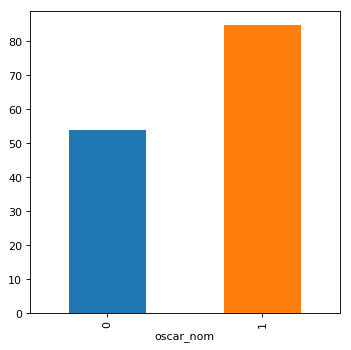

In [8]:
#dfr=df.dropna(subset=['rt_aud_score'])
dfr=df.dropna(subset=['rt_crtics_score'])
from matplotlib.pyplot import figure
oscar_group = dfr.groupby('oscar_nom')
print(oscar_group.mean()["rt_crtics_score"])
figure(num=None, figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')
oscar_group.mean()["rt_crtics_score"].plot(kind='bar')

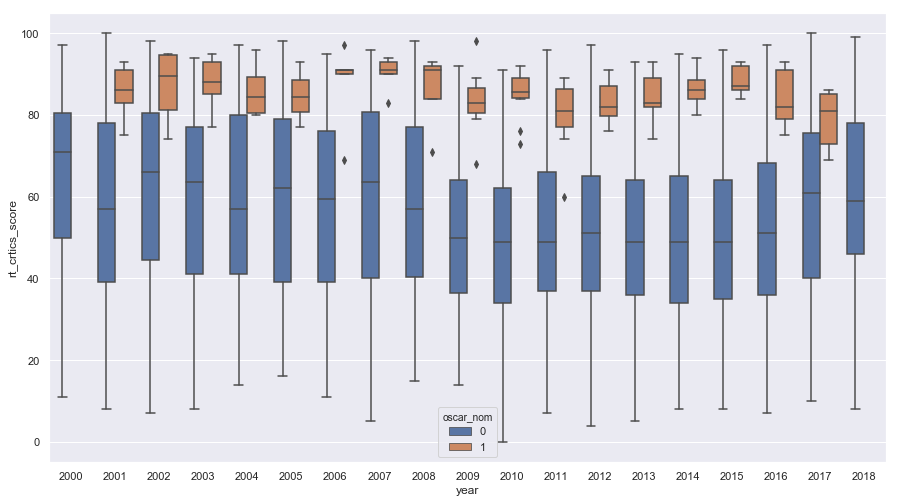

In [9]:
sns.set(rc={'figure.figsize':(15,8.27)})
sns.boxplot(x=df['year'], y=df['rt_crtics_score'], hue=df['oscar_nom'])

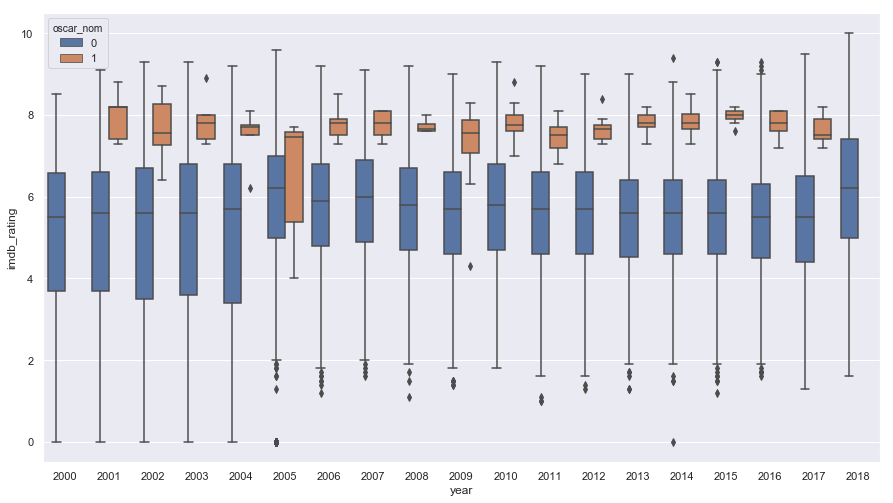

In [10]:
sns.set(rc={'figure.figsize':(15,8.27)})
sns.boxplot(x=df['year'], y=df['imdb_rating'], hue=df['oscar_nom'])

### Runtime
<li> Oscar Nominees tend to have longer runtime

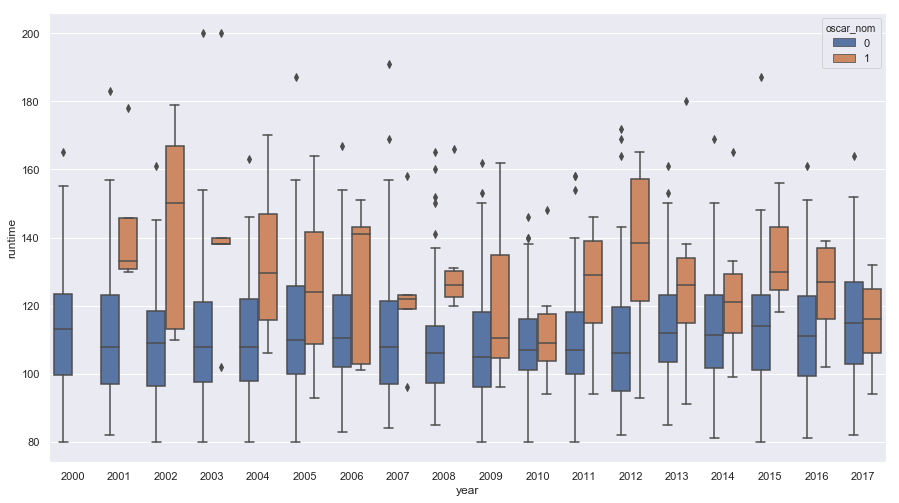

In [11]:
sns.set(rc={'figure.figsize':(15,8.27)})
sns.boxplot(x=oscar_check['year'], y=oscar_check['runtime'], hue=oscar_check['oscar_nom'])

### Box office
<li> Oscar Nominees usually have higher box office

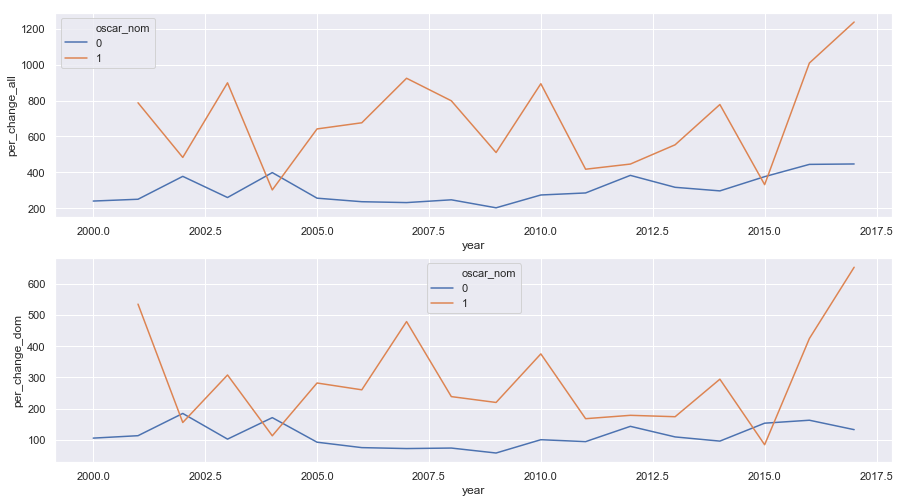

In [12]:
#include films with box office >20
f, axes = plt.subplots(2, 1)
box = oscar_check.query('us_box_office > 20')

### world wide
c = box.groupby(['year', 'oscar_nom'])[['per_change_all']].mean().reset_index()
sns.lineplot('year', 'per_change_all', data=c, hue = 'oscar_nom', ax=axes[0])

# ### domestic
c = box.groupby(['year', 'oscar_nom'])[['per_change_dom']].mean().reset_index()
sns.lineplot('year', 'per_change_dom', data=c, hue = 'oscar_nom',  ax=axes[1])

### Genre
<li> (Comedy, Drama, Romance)  is the most popular genre combination in nomination

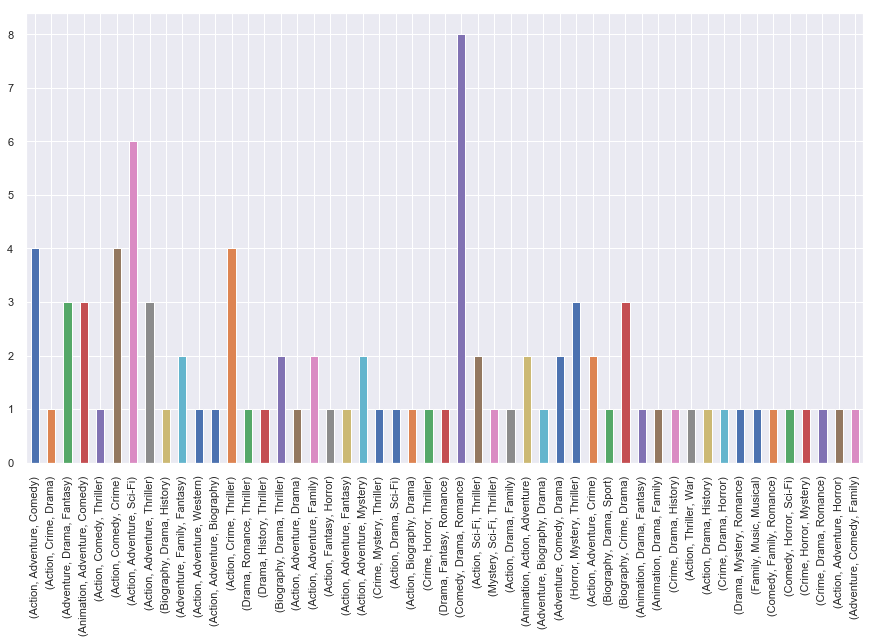

In [14]:
#genre count
df_genre = pd.read_pickle('Final_Unique_datset.pkl')
df_genre = df_genre[['movie_name','oscar_nom','genre1','genre2','genre3']]
df_g = df_genre[(df_genre['oscar_nom']==1) & ((df_genre['genre1']!= 0)|(df_genre['genre2']!= 0)|(df_genre['genre3']!= 0))]
d3 = df_g[df_g['genre3'] != 0]
tri = {}
for i in range(len(d3)):
    g1 = d3.iloc[i]['genre1']
    g2 = d3.iloc[i]['genre2']
    g3 = d3.iloc[i]['genre3']
    if (g1,g2,g3) in tri:
        tri[(g1,g2,g3)]+=1       
    elif (g1,g3,g2) in tri:
        tri[(g1,g3,g2)]+=1    
    elif (g2,g3,g1) in tri:
        tri[(g2,g3,g1)]+=1    
    elif (g2,g1,g3) in tri:
        tri[(g2,g1,g3)]+=1   
    elif (g3,g2,g1) in tri:
        tri[(g3,g2,g1)]+=1   
    elif (g3,g1,g2) in tri:
        tri[(g3,g1,g2)]+=1   
    else:
        tri[(g1,g2,g3)] = 1
g_tri_count = pd.Series(tri)
plt.style.use('seaborn')
sns.set(rc={'figure.figsize':(15, 8.27)})
g_tri_count.plot(kind='bar')

### Release Month
<li> Most oscar movies release during the end of the year

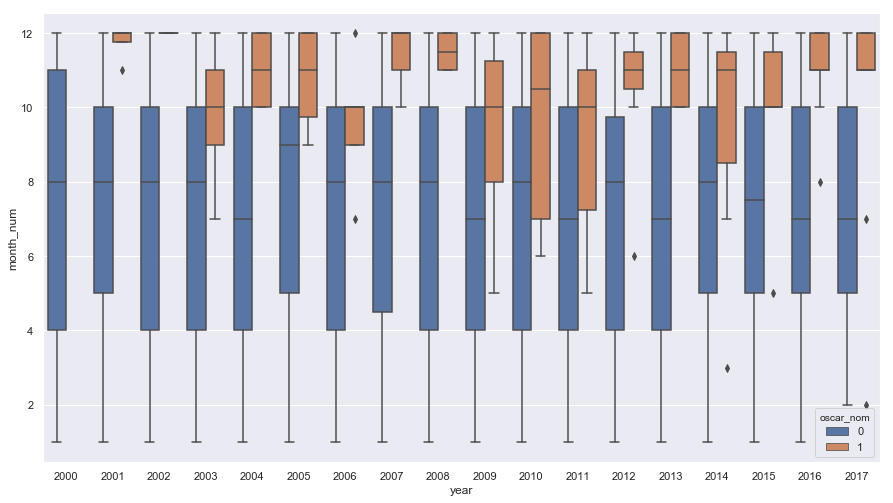

In [16]:
sns.set(rc={'figure.figsize':(15,8.27)})
sns.boxplot(x=oscar_check['year'], y=oscar_check['month_num'], hue=oscar_check['oscar_nom'])

### Other Awards
<li> Critics Choice and BAFTA nominee has 63.84% and 85.19% probability respectively to get oscar nomination

In [15]:
#count by binary values of bafta_award and nomination_cc columns
cc_nom_total = df[df['nomination_cc']==1]['movie_name'].count()
oscar_specified = df[(df['oscar_nom']==1) & (df['nomination_cc']==1)]['movie_name'].count()
percentage = oscar_specified/cc_nom_total*100
print('critics choice: '+"%1.2f%%"%percentage)

bafta_total = df[df['bafta_award']==1]['movie_name'].count()
oscarnom_specified = df[(df['oscar_nom']==1) & (df['bafta_award']==1)]['movie_name'].count()
percentage = oscarnom_specified/bafta_total*100
print('bafta: '+ "%1.2f%%"%percentage)

critics choice: 63.84%
bafta: 85.19%


## LDA Model
<li>The LDA models discover the different topics that the oscar movies and non-oscar movies represent

In [10]:
import ast

In [11]:
#corpus on all movies

df_o = pd.read_csv('updated_movie_from_pickle3.csv')
list_o = []
for i in df_o.index:
    list_o.append(ast.literal_eval(df_o['cleaned_keywords'][i]))
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
import pprint
dictionary = corpora.Dictionary(list_o) #(word_id,frequency) pairs
corpus = [dictionary.doc2bow(text) for text in list_o] #(word_id,freq) pairs by sentence

In [12]:
num_topics = 50 #The number of topics that should be generated
passes = 80
lda = LdaModel(corpus,
              id2word=dictionary,
              num_topics=num_topics,
              passes=passes)

In [14]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(lda.print_topics(num_words=5))

[   (   22,
        '0.057*"alien" + 0.035*"magic" + 0.032*"conspiracy" + 0.026*"drama" + '
        '0.019*"travel"'),
    (   29,
        '0.038*"cia" + 0.033*"terrorism" + 0.030*"killer" + 0.027*"alcoholic" '
        '+ 0.022*"politics"'),
    (   11,
        '0.555*"independent film" + 0.027*"gay relationship" + 0.023*"gay '
        'interest" + 0.021*"1980s" + 0.011*"prostitute"'),
    (   25,
        '0.136*"biography" + 0.072*"based on true story" + 0.052*"sport" + '
        '0.028*"swimming pool" + 0.025*"racism"'),
    (   41,
        '0.065*"christmas" + 0.053*"holiday" + 0.031*"journalist" + '
        '0.027*"possession" + 0.020*"mountain"'),
    (   43,
        '0.097*"dystopia" + 0.059*"prison" + 0.039*"future" + '
        '0.030*"christian" + 0.023*"las vegas"'),
    (   27,
        '0.115*"high school" + 0.050*"student" + 0.035*"doctor" + '
        '0.030*"teenager" + 0.024*"spaceship"'),
    (   28,
        '0.133*"revenge" + 0.070*"death" + 0.033*"murder" + 0.031*"hospi

In [15]:
lda_corpus =lda[corpus]
keyword_weight = [item for item in lda_corpus]

In [16]:
#corpus on nominees
df = pd.read_csv('oscar_movie_recent_years.csv')
list_ = []
for i in df.index:
    list_.append(ast.literal_eval(df['keywords'][i]))
dictionary_ = corpora.Dictionary(list_) #(word_id,frequency) pairs
corpus_ = [dictionary_.doc2bow(text) for text in list_] #(word_id,freq) pairs by sentence
num_topics = 20 #The number of topics that should be generated
passes = 60
lda_o = LdaModel(corpus_,
              id2word=dictionary_,
              num_topics=num_topics,
              passes=passes)


In [17]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(lda_o.print_topics(num_words=5))

[   (   0,
        '0.030*"sword and sorcery" + 0.030*"based on novel" + '
        '0.030*"middle-earth (tolkien)" + 0.030*"elves" + 0.030*"orcs"'),
    (   1,
        '0.029*"monarchy" + 0.029*"royal family" + 0.029*"great britain" + '
        '0.020*"death of father" + 0.020*"speech"'),
    (   2,
        '0.023*"dying and death" + 0.015*"based on novel" + 0.015*"gay" + '
        '0.015*"literature" + 0.015*"sport"'),
    (   3,
        '0.020*"boston" + 0.020*"lawyer" + 0.020*"journalism" + 0.020*"court" '
        '+ 0.020*"child abuse"'),
    (   4,
        '0.025*"drug traffic" + 0.025*"united states–mexico barrier" + '
        '0.017*"hitman" + 0.017*"texas" + 0.017*"suspense"'),
    (   5,
        '0.012*"1950s" + 0.012*"ship" + 0.012*"arbitrary law" + 0.012*"writer" '
        '+ 0.012*"based on novel"'),
    (   6,
        '0.018*"based on play or musical" + 0.018*"jazz age" + 0.018*"prison '
        'matron" + 0.018*"chicago" + 0.018*"nude man murdered"'),
    (   7,
        '

In [18]:
from operator import itemgetter
lda_o.get_document_topics(corpus_[100],minimum_probability=0.05,per_word_topics=False)
sorted(lda_o.get_document_topics(corpus_[24],minimum_probability=0,per_word_topics=False),key=itemgetter(1),reverse=True)
lda_corpus =lda_o[corpus_]
keyword_weight = [item for item in lda_corpus]

###  Oscar nominees
<li> Data from 2000-2017 oscar nominated movies

In [19]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda_o, corpus_, dictionary_, sort_topics=False)
pyLDAvis.display(lda_display)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


### All movies
<li> Data from clean_ver_3.pkl

In [20]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


## Sentiment Analysis
<li> Oscar nominees have a higher positive/negative keywords ratio = 42%
<li> The ratio for all movie is 28%
<li> Oscar nominated movies' topics are more positive

In [27]:
#words lists
def get_pos_neg_words():
    def get_words(url):
        import requests
        words = requests.get(url).content.decode('latin-1')
        word_list = words.split('\n')
        index = 0
        while index < len(word_list):
            word = word_list[index]
            if ';' in word or not word:
                word_list.pop(index)
            else:
                index+=1
        return word_list

    #Get lists of positive and negative words
    p_url = 'http://ptrckprry.com/course/ssd/data/positive-words.txt'
    n_url = 'http://ptrckprry.com/course/ssd/data/negative-words.txt'
    positive_words = get_words(p_url)
    negative_words = get_words(n_url)
    return positive_words,negative_words

positive_words,negative_words = get_pos_neg_words()

#### Oscar nominees

In [30]:
with open('word_oscar_cleaned.txt','r') as f:
    word_oscar = f.read()

In [60]:
def do_pos_neg_sentiment_analysis(text_list,debug=False):
    positive_words,negative_words = get_pos_neg_words()
    from nltk import word_tokenize
    results = list()
    for text in text_list:
        cpos = cneg = lpos = lneg = 0
        for word in word_tokenize(text[1]):
            if word in positive_words:
                if debug:
                    print("Positive",word)
                cpos+=1
            if word in negative_words:
                if debug:
                    print("Negative",word)
                cneg+=1
        results.append((text[0],cpos/len(word_tokenize(text[1])),cneg/len(word_tokenize(text[1]))))
    [(text,pos, neg)] = results
    return pos/(neg)

do_pos_neg_sentiment_analysis([('word_oscar',word_oscar)]) #positive vs. negative

0.4222222222222222

#### All movies

In [32]:
with open('keywords_cleaned.txt','r') as f2:
    word_total = f2.read()

In [59]:
def do_pos_neg_sentiment_analysis(text_list,debug=False):
    positive_words,negative_words = get_pos_neg_words()
    from nltk import word_tokenize
    results = list()
    for text in text_list:
        cpos = cneg = lpos = lneg = 0
        for word in word_tokenize(text[1]):
            if word in positive_words:
                if debug:
                    print("Positive",word)
                cpos+=1
            if word in negative_words:
                if debug:
                    print("Negative",word)
                cneg+=1
        results.append((text[0],cpos/len(word_tokenize(text[1])),cneg/len(word_tokenize(text[1]))))
    [(text,pos, neg)] = results
    return pos/(neg)

do_pos_neg_sentiment_analysis([('word_total',word_total)]) #positive vs. negative

0.28130443589224224

# Modeling

### Check correlation

<li>imdb_rating and meta_score are corr - 0.65 -  think of combining them
<li>imdb votes and rating are also correlated - 0.59
<li>imdb_rating and rt critics/rt_aud_score score are also strongly correlated (0.78). combine all of them 
<li>imdb_votes and box office - 0.64 - means how popular movie is
<li>us_box_office, domestice gross and world wde gross are 0.99 correlated. Just take us_box_office

In [9]:

x = oscar_check.corr()
x[(x > 0.5) | (x < -0.5)]
x[(x > 0.3) | (x < -0.3)]
x

,year,runtime,imdb_rating,metascore,imdb_votes,us_box_office,oscar_nom,budget,domestic_gross,world_wide_gross,...,Reality-TV,Romance,Sci-Fi,Sport,Thriller,War,Western,month_num,binary_count_dir,binary_count_actor
year,1.000000,0.035755,0.030241,0.063979,0.036836,0.109940,0.073365,0.152648,0.127299,0.185169,...,NaN,-0.086219,0.057538,-0.040906,-0.030480,-0.024197,0.026936,0.003998,-0.036399,-0.076366
runtime,0.035755,1.000000,0.364750,0.179708,0.388962,0.271090,0.221921,0.344628,0.249961,0.267576,...,NaN,-0.044496,0.069047,0.046976,0.024930,0.072371,0.065443,0.185072,0.221553,0.248868
imdb_rating,0.030241,0.364750,1.000000,0.643471,0.597668,0.260610,0.398679,0.089318,0.265380,0.253980,...,NaN,-0.071119,0.030688,0.036578,-0.035990,0.012394,0.002309,0.232311,0.152567,0.191747
metascore,0.063979,0.179708,0.643471,1.000000,0.343164,0.188074,0.412338,0.027037,0.199468,0.172746,...,NaN,-0.053207,-0.002838,-0.020605,-0.038082,-0.009527,-0.017154,0.265951,0.174057,0.162197
imdb_votes,0.036836,0.388962,0.597668,0.343164,1.000000,0.642652,0.303828,0.455376,0.638211,0.614367,...,NaN,-0.120118,0.259841,-0.078689,0.064289,-0.011403,0.028914,0.060680,0.126032,0.192715
us_box_office,0.109940,0.271090,0.260610,0.188074,0.642652,1.000000,0.079217,0.696830,0.998789,0.937718,...,NaN,-0.154208,0.192692,-0.051037,-0.037524,-0.047659,0.002256,-0.015608,0.012425,0.079668
oscar_nom,0.073365,0.221921,0.398679,0.412338,0.303828,0.079217,1.000000,-0.041398,0.084600,0.077200,...,NaN,-0.021993,-0.016334,0.010579,-0.025499,0.038800,0.049689,0.229886,0.266576,0.148212
budget,0.152648,0.344628,0.089318,0.027037,0.455376,0.696830,-0.041398,1.000000,0.698190,0.771799,...,NaN,-0.205516,0.223297,-0.068298,-0.043834,-0.002652,0.044855,-0.020769,0.048857,0.147766
domestic_gross,0.127299,0.249961,0.265380,0.199468,0.638211,0.998789,0.084600,0.698190,1.000000,0.938777,...,NaN,-0.146579,0.192217,-0.041582,-0.039673,-0.049441,0.006714,-0.029619,0.020359,0.081227
world_wide_gross,0.185169,0.267576,0.253980,0.172746,0.614367,0.937718,0.077200,0.771799,0.938777,1.000000,...,NaN,-0.146752,0.191662,-0.078981,-0.028679,-0.046293,0.000851,-0.004368,0.031351,0.096749


## Logistic Regression 

In [63]:
#setup
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [64]:
#df clean
oscar_check = oscar_check[['year', 'runtime','imdb_rating', 'metascore', 'imdb_votes', 'us_box_office', 'budget', 'domestic_gross',
                 'world_wide_gross', 'film_fes', 'per_change_dom', 'per_change_all', 'rt_crtics_score', 'nomination_cc', 'bafta_award', 
                 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 
                 'Family', 'Fantasy', 'History', 'Horror', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance',
                 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western', 'month_num', 'binary_count_dir', 'binary_count_actor', 'oscar_nom','nomination_cc']]
oscar_check=oscar_check.dropna()
y=oscar_check['oscar_nom']
X=oscar_check.drop(columns='oscar_nom')

In [65]:
# train/test split with test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Confusion Matrix
<li>With threshold = 0.25 
<li> True Positive = 14, predict 3 nominees wrong
<li> True Negative = 215, predict 14 non-oscar movies wrong

In [73]:
THRESHOLD = 0.25
y_pred = np.where(classifier.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
pd.DataFrame(confusion_matrix, index = ['Actual_No','Actual_Yes'], columns = ['Predicted_No', 'Predicted_Yes'])

,Predicted_No,Predicted_Yes
Actual_No,215,14
Actual_Yes,3,14


#### Model Sensitivity
<li>Accuracy: Overall, how often is the classifier correct?
<li>Sensitivity/True Positive: When it's actually yes, how often does it predict yes?
<li>Precision: When it predicts yes, how often is it correct?

In [76]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score
pd.DataFrame(data=[accuracy_score(y_test, y_pred), recall_score(y_test, y_pred),
                   precision_score(y_test, y_pred), roc_auc_score(y_test, y_pred)], 
             index=["accuracy", "sensitivity", "precision", "roc_auc_score"])

,0
accuracy,0.930894
sensitivity,0.823529
precision,0.500000
roc_auc_score,0.881197


## Random Forest
<li>A model good at classification.
<li>Operate by constructing multiple decision trees at training time
<li>Outputting the class that is the mode of the classes (classification)of the individual trees.
    
### with bafta and critics choice binary variables

In [7]:
### Clean some wrongly awards
Oscar_data.loc[(Oscar_data['movie_name']=='room') & (Oscar_data['year']==2005),'oscar_nom'] = 0
Oscar_data.loc[(Oscar_data['movie_name']=='darkest hour') & (Oscar_data['year']==2005),'oscar_nom'] = 0
Oscar_data.loc[(Oscar_data['movie_name']=='the fighter') & (Oscar_data['year']==2009),'oscar_nom'] = 0
Oscar_data.loc[(Oscar_data['movie_name']=='the revenant') & (Oscar_data['year']==2009),'oscar_nom'] = 0
Oscar_data.loc[(Oscar_data['movie_name']=='gravity') & (Oscar_data['year']==2004),'oscar_nom'] = 0
Oscar_data.loc[(Oscar_data['movie_name']=='whiplash') & (Oscar_data['year']==2002),'oscar_nom'] = 0
oscars = Oscar_data.query("oscar_nom==1")

In [79]:
o_df1 = Oscar_data[(Oscar_data['us_box_office'] >= 5) & (Oscar_data['imdb_rating'] >= 6) 
             & (Oscar_data['year'] < 2018) & (Oscar_data['oscar_nom'] != 1)  ]
o_df2 = pd.concat([o_df1, oscars])
o_df_b = o_df2[['year', 'runtime','imdb_rating', 'metascore', 'imdb_votes', 
              'film_fes', 'per_change_dom',
             'Action', 'Adventure', 'Animation', 
             'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Musical', 
             'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western', 
             'month_num', 'binary_count_dir', 'binary_count_actor', 'bafta_award', 'nomination_cc','oscar_nom']]
o_df_b = o_df_b.dropna(axis = 0)

In [80]:
#train on data 2000-2014, test on data 2015-2017
train = o_df_b.query("year <= 2014")
test = o_df_b.query("(year > 2014) and (year < 2018)")
x_train = train.iloc[0:,0:-1]
y_train = train[['oscar_nom']]
x_test = test.iloc[0:,0:-1]
x_test_out = test.iloc[:]
y_test = test[['oscar_nom']]
from sklearn.ensemble import RandomForestClassifier

### try various versions of trees
model = RandomForestClassifier(n_estimators=30, random_state=50)
#np.ravel flattens the pandas Series into an np array. That's what the classifier needs
model.fit(x_train,np.ravel(y_train))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=50, verbose=0, warm_start=False)

#### F-score with different threshold
<li> Threshold = 0.3 returns the highest F-score = 87.5%
<li> Inbalanced dataset with more non-oscar movies and a few nominees

In [81]:
### without balanced weight tree
from sklearn.metrics import accuracy_score #works
#threshold = 0.3
for threshold in np.arange(0.1, 0.9, 0.1):

    y_pred = model.predict_proba(x_test)
    y_pred_extra = y_pred [:,1]
    #print(y_pred)
    #y_pred [:,0] = (predicted [:,0] < threshold).astype('int')
    #y_pred [:,1] = (predicted [:,1] >= threshold).astype('int')
    y_pred = (y_pred [:,1] >= threshold).astype('int')
    cfm = confusion_matrix(np.ravel(y_test),y_pred)
    tn, fp, fn, tp = confusion_matrix(np.ravel(y_test),y_pred).ravel()
    print("\n")
    print(sum(y_pred), len(y_pred))
    print("threshold:", threshold, '\n', cfm)
    print("Acc.", accuracy_score(y_test, y_pred))  ### (TP+TN)/total
    tpr = tp/(tp+fn)
    print("TPR/Recall:", tpr)
    print("True Neg:", tn/(tn+fp))
    print("False Pos.", fp/(fp+tn))
    print("Precision", tp/(tp+fp))
    precision = tp/(tp+fp)
    print("F-score", precision*tpr/(precision+tpr)*2)



37 231
threshold: 0.1 
 [[194  14]
 [  0  23]]
Acc. 0.9393939393939394
TPR/Recall: 1.0
True Neg: 0.9326923076923077
False Pos. 0.0673076923076923
Precision 0.6216216216216216
F-score 0.7666666666666667


29 231
threshold: 0.2 
 [[201   7]
 [  1  22]]
Acc. 0.9653679653679653
TPR/Recall: 0.9565217391304348
True Neg: 0.9663461538461539
False Pos. 0.03365384615384615
Precision 0.7586206896551724
F-score 0.8461538461538461


25 231
threshold: 0.30000000000000004 
 [[204   4]
 [  2  21]]
Acc. 0.974025974025974
TPR/Recall: 0.9130434782608695
True Neg: 0.9807692307692307
False Pos. 0.019230769230769232
Precision 0.84
F-score 0.8749999999999999


22 231
threshold: 0.4 
 [[205   3]
 [  4  19]]
Acc. 0.9696969696969697
TPR/Recall: 0.8260869565217391
True Neg: 0.9855769230769231
False Pos. 0.014423076923076924
Precision 0.8636363636363636
F-score 0.8444444444444444


19 231
threshold: 0.5 
 [[205   3]
 [  7  16]]
Acc. 0.9567099567099567
TPR/Recall: 0.6956521739130435
True Neg: 0.9855769230769231


#### ROC curve

AUC: 0.696


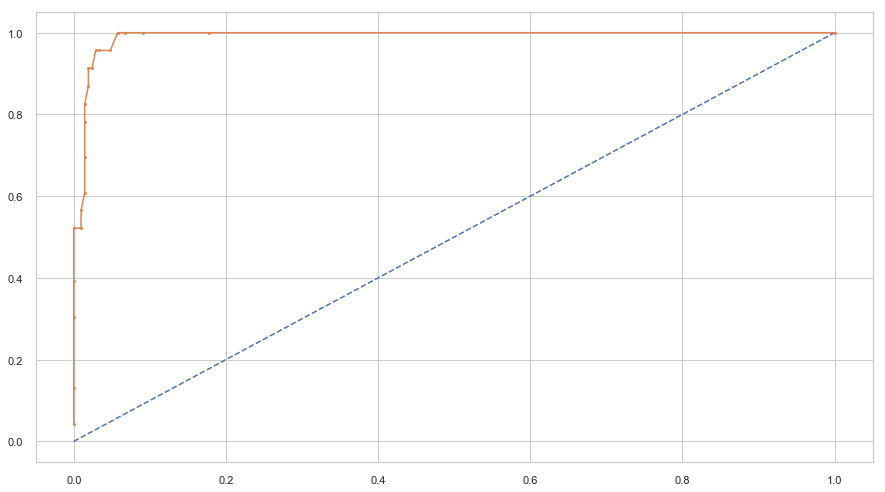

In [43]:
#plot roc curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
auc = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc)
# calculate roc csurve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_extra)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

#### Confusion Matrix
<li>With threshold = 0.3 
<li> True Positive = 21, predict 2 nominees wrong
<li> True Negative = 203, predict 5 non-oscar movies wrong

In [87]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict_proba(x_test)
y_pred = (y_pred [:,1] >= 0.3).astype('int')
cfm = confusion_matrix(np.ravel(y_test),y_pred)
pd.DataFrame(cfm, index = ['Actual_No','Actual_Yes'], columns = ['Predicted_No', 'Predicted_Yes'])

,Predicted_No,Predicted_Yes
Actual_No,203,5
Actual_Yes,2,21


### without other awards
#### Oscar, BAFTA and Critics Choice nominations are higher correlated
<li> Correlation between bafta nomination and oscar nomoination is 0.67
<li> Correlation between bafta nomination and critics choice nomoination is 0.74
<li> So maybe remove such strong indicator variables...

In [8]:
dfb = Oscar_data[['movie_name','bafta_award', 'nomination_cc','oscar_nom']]
dfb.corr()

,bafta_award,nomination_cc,oscar_nom
bafta_award,1.000000,0.666680,0.673766
nomination_cc,0.666680,1.000000,0.738854
oscar_nom,0.673766,0.738854,1.000000


In [9]:
#data removing nomination_cc and bafta_award
o_df1 = Oscar_data[(Oscar_data['us_box_office'] >= 5) & (Oscar_data['imdb_rating'] >= 6) 
             & (Oscar_data['year'] < 2018) & (Oscar_data['oscar_nom'] != 1)  ]
o_df2 = pd.concat([o_df1, oscars])
o_df = o_df2[['year', 'runtime','imdb_rating', 'metascore', 'imdb_votes', 
              'film_fes', 'per_change_dom',
             'Action', 'Adventure', 'Animation', 
             'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Musical', 
             'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western', 
             'month_num', 'binary_count_dir', 'binary_count_actor', 'oscar_nom']]
o_df = o_df.dropna(axis = 0)

In [10]:
#train on 2000-2014, test on 2015-2017, same model setup
train = o_df.query("year <= 2014")
test = o_df.query("(year > 2014) and (year < 2018)")
x_train = train.iloc[0:,0:-1]
y_train = train[['oscar_nom']]
x_test = test.iloc[0:,0:-1]
x_test_out = test.iloc[:]
y_test = test[['oscar_nom']]
from sklearn.ensemble import RandomForestClassifier

### try various versions of trees
model = RandomForestClassifier(n_estimators=30, random_state=50)
#np.ravel flattens the pandas Series into an np array. That's what the classifier needs
model.fit(x_train,np.ravel(y_train))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=50, verbose=0, warm_start=False)

#### F-score with different threshold
<li> Threshold = 0.3 returns the highest F-score = 75%
<li> Inbalanced dataset with more non-oscar movies and a few nominees
<li> Removing variables about other awards reduces accuracy and sensitivity of the model

In [12]:
### without balanced weight tree
from sklearn.metrics import accuracy_score #works
from sklearn.metrics import confusion_matrix
for threshold in np.arange(0.1, 0.9, 0.1):

    y_pred = model.predict_proba(x_test)
    y_pred_extra = y_pred [:,1]
    #print(y_pred)
    #y_pred [:,0] = (predicted [:,0] < threshold).astype('int')
    #y_pred [:,1] = (predicted [:,1] >= threshold).astype('int')
    y_pred = (y_pred [:,1] >= threshold).astype('int')
    cfm = confusion_matrix(np.ravel(y_test),y_pred)
    tn, fp, fn, tp = confusion_matrix(np.ravel(y_test),y_pred).ravel()
    print("\n")
    print(sum(y_pred), len(y_pred))
    print("threshold:", threshold, '\n', cfm)
    print("Acc.", accuracy_score(y_test, y_pred))  ### (TP+TN)/total
    tpr = tp/(tp+fn)
    print("TPR/Recall:", tpr)
    print("True Neg:", tn/(tn+fp))
    print("False Pos.", fp/(fp+tn))
    print("Precision", tp/(tp+fp))
    precision = tp/(tp+fp)
    print("F-score", precision*tpr/(precision+tpr)*2)  



53 231
threshold: 0.1 
 [[178  30]
 [  0  23]]
Acc. 0.8701298701298701
TPR/Recall: 1.0
True Neg: 0.8557692307692307
False Pos. 0.14423076923076922
Precision 0.4339622641509434
F-score 0.6052631578947368


32 231
threshold: 0.2 
 [[196  12]
 [  3  20]]
Acc. 0.935064935064935
TPR/Recall: 0.8695652173913043
True Neg: 0.9423076923076923
False Pos. 0.057692307692307696
Precision 0.625
F-score 0.7272727272727273


25 231
threshold: 0.30000000000000004 
 [[201   7]
 [  5  18]]
Acc. 0.948051948051948
TPR/Recall: 0.782608695652174
True Neg: 0.9663461538461539
False Pos. 0.03365384615384615
Precision 0.72
F-score 0.7499999999999999


20 231
threshold: 0.4 
 [[204   4]
 [  7  16]]
Acc. 0.9523809523809523
TPR/Recall: 0.6956521739130435
True Neg: 0.9807692307692307
False Pos. 0.019230769230769232
Precision 0.8
F-score 0.7441860465116279


13 231
threshold: 0.5 
 [[207   1]
 [ 11  12]]
Acc. 0.948051948051948
TPR/Recall: 0.5217391304347826
True Neg: 0.9951923076923077
False Pos. 0.00480769230769230

#### ROC curve

AUC: 0.522


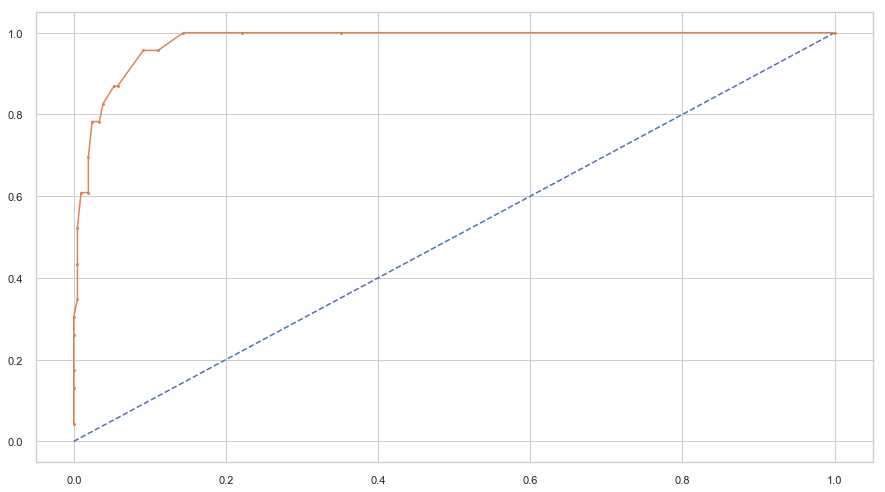

In [52]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
auc = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc)
# calculate roc csurve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_extra)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

#### Confusion Matrix
<li>With threshold = 0.3 
<li> True Positive = 19, predict 4 nominees wrong
<li> True Negative = 20, predict 8 non-oscar movies as oscar nominated

In [13]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict_proba(x_test)
y_pred = (y_pred [:,1] >= 0.3).astype('int')
cfm2 = confusion_matrix(np.ravel(y_test),y_pred)
pd.DataFrame(cfm2, index = ['Actual_No','Actual_Yes'], columns = ['Predicted_No', 'Predicted_Yes'])

,Predicted_No,Predicted_Yes
Actual_No,200,8
Actual_Yes,4,19


#### Decision Tree
<li> Illustrating one of the decision trees of Random Forest Model

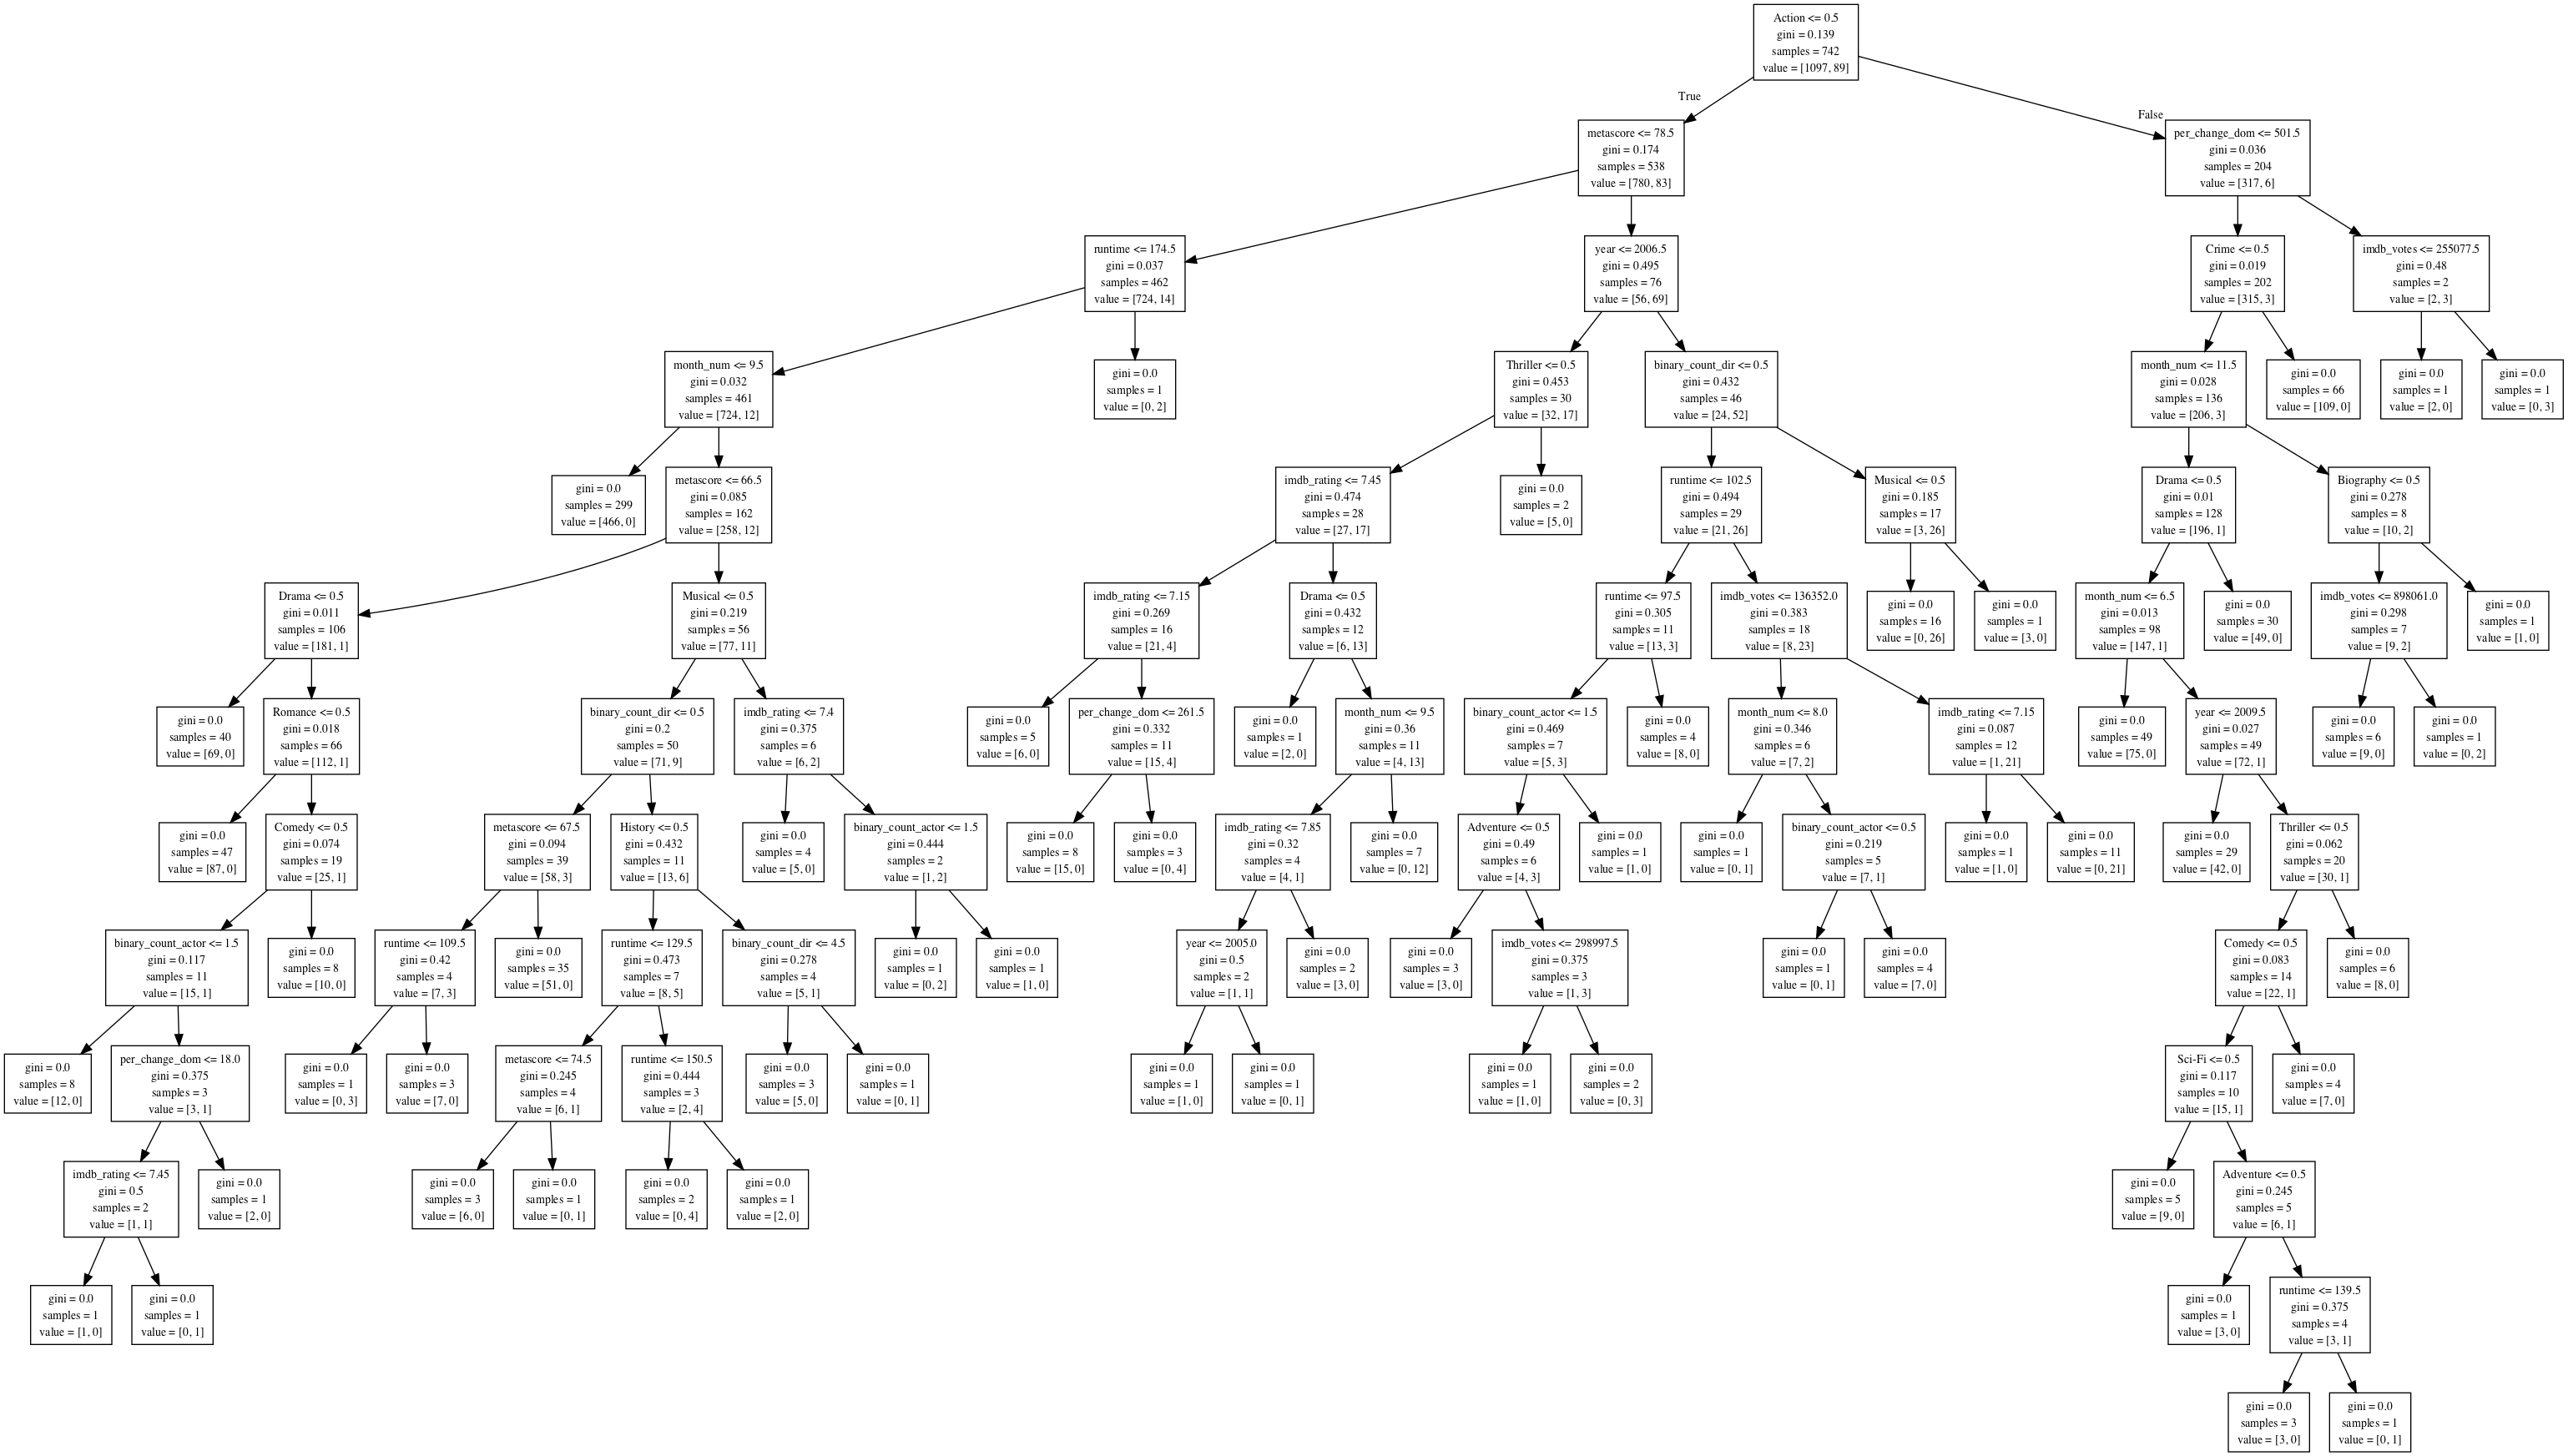

In [56]:
#decision tree plot 
from sklearn.tree import export_graphviz
estimator = model.estimators_[29]
export_graphviz(estimator, out_file='tree.dot', feature_names = x_train.columns
                )

import os

from subprocess import call
os.system('dot -Tpng tree.dot -o tree.png')


# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')


#### Feature Importance
Important features mean the features that are more closely related with dependent variable and contribute more for variation of the dependent variable.

Text(0.5,0,'Relative Importance')

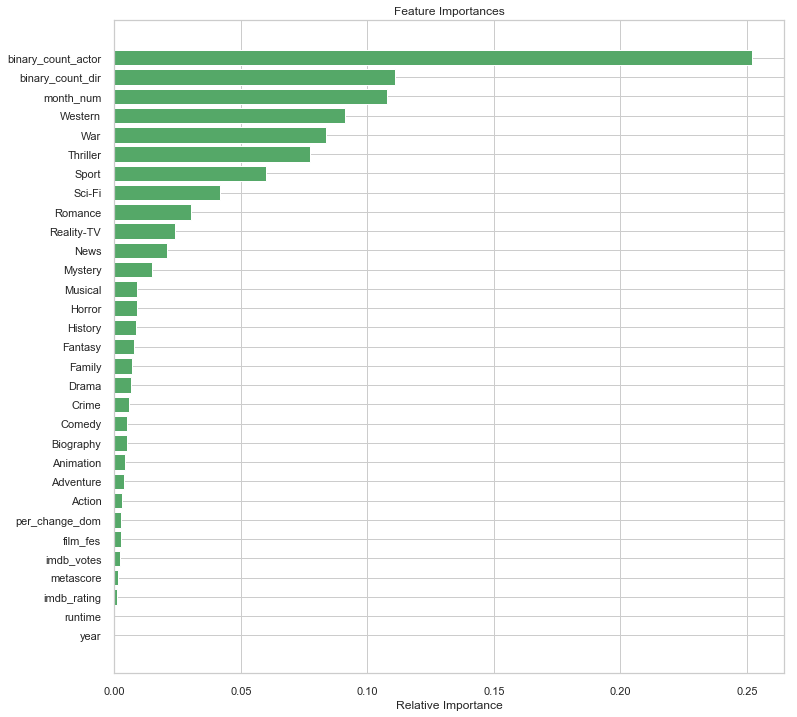

In [110]:
feature_names = [key for key in o_df if not key=='oscar_nom']
%matplotlib inline
importances = model.feature_importances_
indices = np.argsort(importances)
importances
plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)),feature_names)
plt.xlabel('Relative Importance')

#### Reflection on wrong predictions

In [89]:
y_pred = model.predict(x_test)
y_test['preds'] = y_pred
df_out = pd.merge(x_test_out,y_test[['preds']],how = 'left',left_index = True, right_index = True)
df_out = df_out.merge(o_df2[['movie_name']],how = 'left', left_index = True, right_index = True)
df_out.query("oscar_nom == 1")

/Users/qinchensun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,year,runtime,imdb_rating,metascore,imdb_votes,film_fes,per_change_dom,Action,Adventure,Animation,...,War,Western,month_num,binary_count_dir,binary_count_actor,bafta_award,nomination_cc,oscar_nom,preds,movie_name
1252,2017,106,7.9,94,428921,0,27.0,1,0,0,...,0,0,7.0,0.0,0,1,1,1,1,dunkirk
1257,2017,104,7.7,84,344001,0,3420.0,0,0,0,...,0,0,2.0,0.0,1,0,1,1,0,get out
1261,2017,115,8.2,88,294116,1,358.0,0,0,0,...,0,0,11.0,0.0,2,1,1,1,1,three billboards outside ebbing missouri
1263,2017,123,7.4,87,264078,1,220.0,0,1,0,...,0,0,12.0,0.0,0,1,1,1,1,the shape of water
1279,2017,94,7.5,94,153903,1,390.0,0,0,0,...,0,0,11.0,0.0,1,0,1,1,1,lady bird
1290,2017,125,7.4,75,118760,1,87.0,0,0,0,...,0,0,11.0,0.0,0,1,1,1,1,darkest hour
1299,2017,116,7.2,83,93664,0,64.0,0,0,0,...,0,0,12.0,6.0,2,0,1,1,1,the post
2503,2016,116,7.9,81,479030,1,115.0,0,0,0,...,0,0,11.0,0.0,2,1,1,1,1,arrival
2506,2016,128,8.1,93,402838,1,655.0,0,0,0,...,0,0,12.0,0.0,0,1,1,1,1,la la land
2508,2016,139,8.1,71,341354,0,68.0,0,0,0,...,0,0,11.0,0.0,0,0,1,1,0,hacksaw ridge
